# This is breast cancer classification project
**Information about data can be found in "SEER Breast Cancer Dataset.pdf" file**

### Analysis is divided in several parts:
* [Data reading and cleaning](#Data-reading-and-cleaning)
* [EDA + Visualizations](#EDA-+-Visualizations)
* [Models](#Models)

In [1]:
# some base imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# additional imports
import sys
first_steps_path = r"..\utils\common_utils"
if first_steps_path not in sys.path:
    sys.path.append(first_steps_path)
from first_steps import first_descriptions
# some basic settings
pd.set_option('display.max_columns', 100)

plt.style.use('seaborn-v0_8-deep')

%load_ext autoreload
%autoreload 2

# Data reading and cleaning

In [2]:
cancer_raw_data = pd.read_csv("SEER Breast Cancer Dataset .csv")
# there are mistake in data, so it has fully-nulled column, so we drop it
cancer_raw_data = cancer_raw_data.drop('Unnamed: 3', axis = 1)

In [3]:
first_descriptions(cancer_raw_data)

************************************************* Dataset first description **************************************************
****************************************************** Head of dataset *******************************************************


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


*************************************************** Pandas-Generated info ****************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   Grade                   4024 non-null   object
 7   A Stage                 4024 non-null   object
 8   Tumor Size              4024 non-null   int64 
 9   Estrogen Status         4024 non-null   object
 10  Progesterone Status     4024 non-null   object
 11  Regional Node Examined  4024 non-null   int64 
 12  Reginol Node Positive   4024 non-

None

************************************************ Categorical features unique *************************************************
Race 
['Other (American Indian/AK Native, Asian/Pacific Islander)' 'White'
 'Black'] 

Marital Status
['Married (including common law)' 'Divorced' 'Single (never married)'
 'Widowed' 'Separated'] 

T Stage 
['T2' 'T1' 'T3' 'T4'] 

N Stage
['N3' 'N2' 'N1'] 

6th Stage
['IIIC' 'IIIA' 'IIB' 'IIA' 'IIIB'] 

Grade
['Moderately differentiated; Grade II' 'Poorly differentiated; Grade III'
 'Well differentiated; Grade I' 'Undifferentiated; anaplastic; Grade IV'] 

A Stage
['Regional' 'Distant'] 

Estrogen Status
['Positive' 'Negative'] 

Progesterone Status
['Positive' 'Negative'] 

Status
['Alive' 'Dead'] 

****************************************************** Dublicate check *******************************************************
Number of dublicates is : 1
********************************************************* NaN check ******************************************

### Data cleaning plan:
* **Seems like we have single dublicate, we'll delete it**  
* **Some categorical features can be transformed in 0 or 1**  
* **We'll separate data from target column** 
* **Columns need some renaming**
* **Some categorical features need better naming e.g. stage names can be shorten**

In [4]:
# drop dublicates
cancer_raw_data = cancer_raw_data.drop_duplicates()
assert cancer_raw_data.duplicated().sum() == 0

In [5]:
# boolean columns transform
boolean_columns = [
    'Estrogen Status',
    'Progesterone Status'
]
for column in boolean_columns:
    cancer_raw_data[column] = pd.to_numeric(cancer_raw_data[column].apply(lambda x: 1 if x=='Positive' else 0))

In [6]:
# target transform
target = pd.to_numeric(cancer_raw_data['Status'].apply(lambda x: 1 if x=='Dead' else 0))
cancer_raw_data['Status'] = pd.to_numeric(cancer_raw_data['Status'].apply(lambda x: 1 if x=='Dead' else 0))

In [7]:
# columns renaming
cancer_raw_data.columns = [
    'age',
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage',
    'tumor_size',
    'estrogen_status',
    'progesterone_status',
    'regional_node_examined',
    'regional_node_positive',
    'survival_month',
    'status'
]

# cat values renaming
cancer_raw_data.race = cancer_raw_data.race.apply(
    lambda x: "Other" if x=='Other (American Indian/AK Native, Asian/Pacific Islander)' else x
)

cancer_raw_data.mariage = cancer_raw_data.mariage.apply(
    lambda x: "Married" if x == 'Married (including common law)' 
    else "Single" if x == 'Single (never married)' else x
)

cancer_raw_data.grade = cancer_raw_data.grade.apply(
    lambda x: 
    "I" if x=='Well differentiated; Grade I' else
    "II" if x=='Moderately differentiated; Grade II' else
    "III" if x=='Poorly differentiated; Grade III' else
    "IV" if x=='Undifferentiated; anaplastic; Grade IV' else x
)

In [8]:
cancer_data = cancer_raw_data.copy()

# EDA + Visualizations

### First check distribution of target

In [9]:
target.value_counts()

0    3407
1     616
Name: Status, dtype: int64

**Looks like we have unbalanced classes  
In that case we'll learn and apply some techniques to fix it further on in modeling**

### Let's plot feature distributions

In [10]:
numerical_features = [
    'age',
    'tumor_size',
    'regional_node_examined',
    'regional_node_positive',
    'survival_month',
]
categorical_features = [
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage',
    'estrogen_status',
    'progesterone_status',
]
print(len(categorical_features))
print(len(numerical_features))

9
5


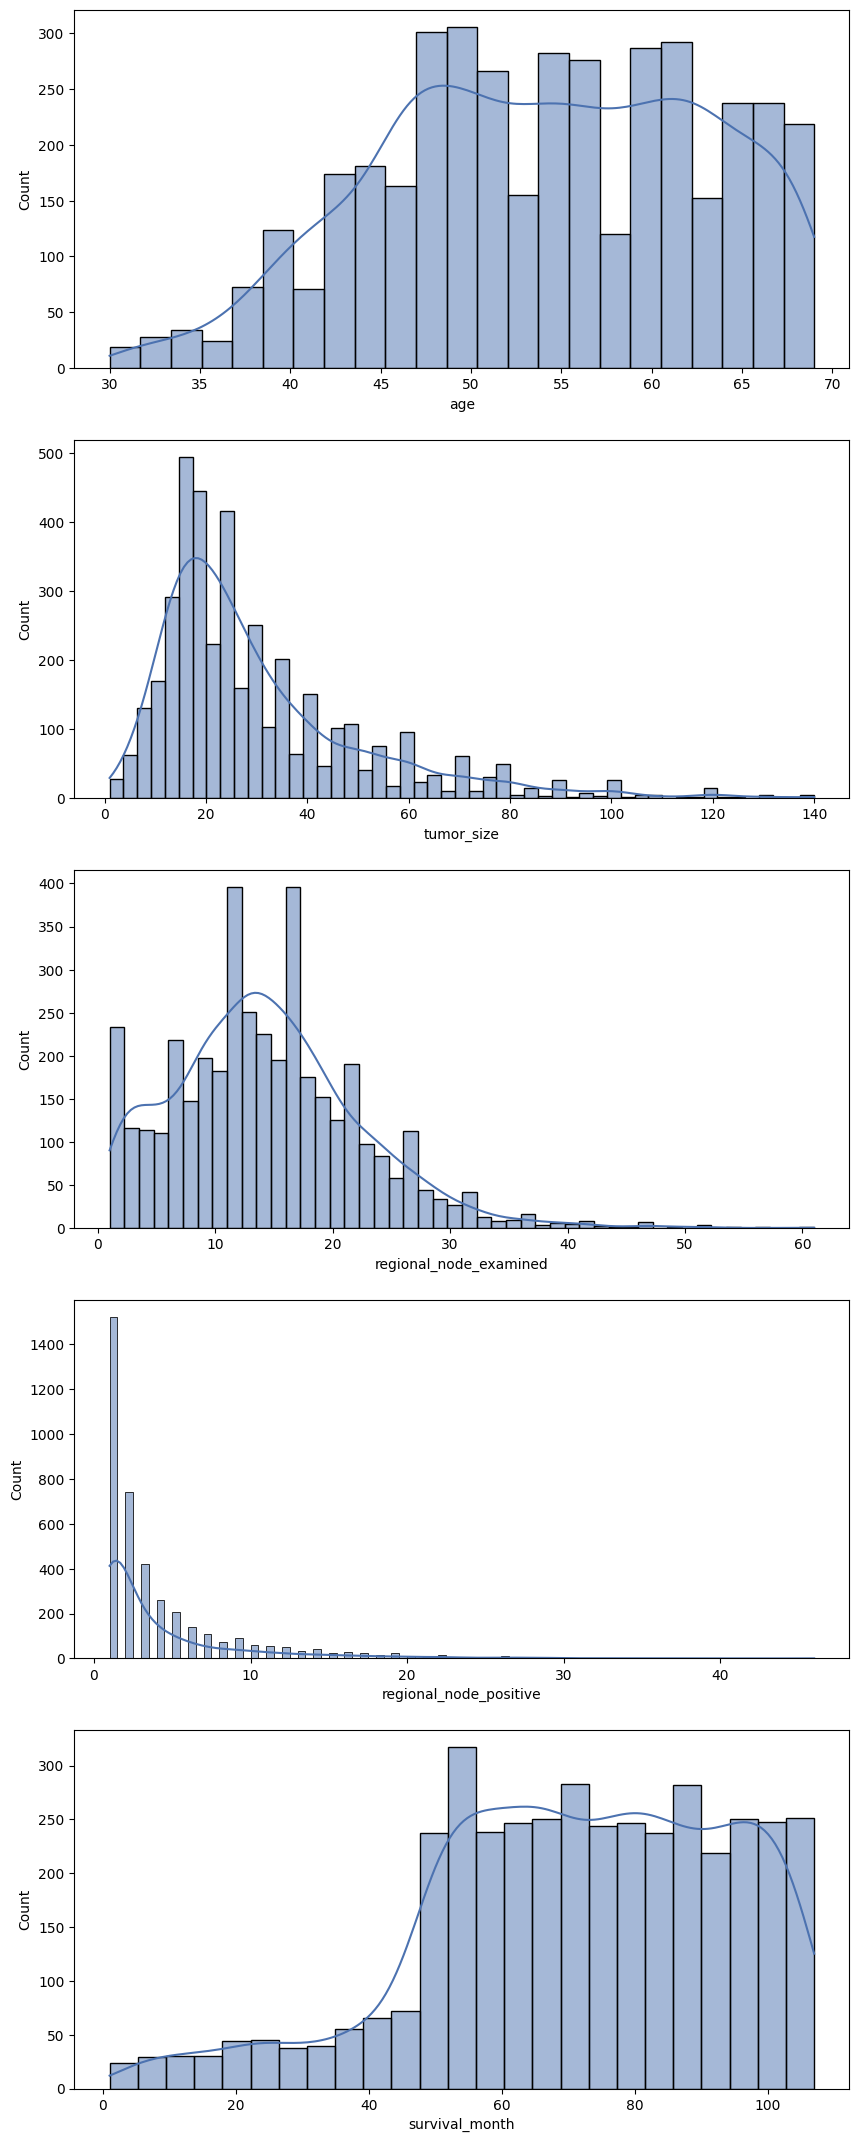

In [11]:
fig, ax = plt.subplots(5, 1, figsize=(10,27))
for i, axs in enumerate(ax.flatten()):
    sns.histplot(cancer_data[numerical_features[i]], ax=axs, kde=True)

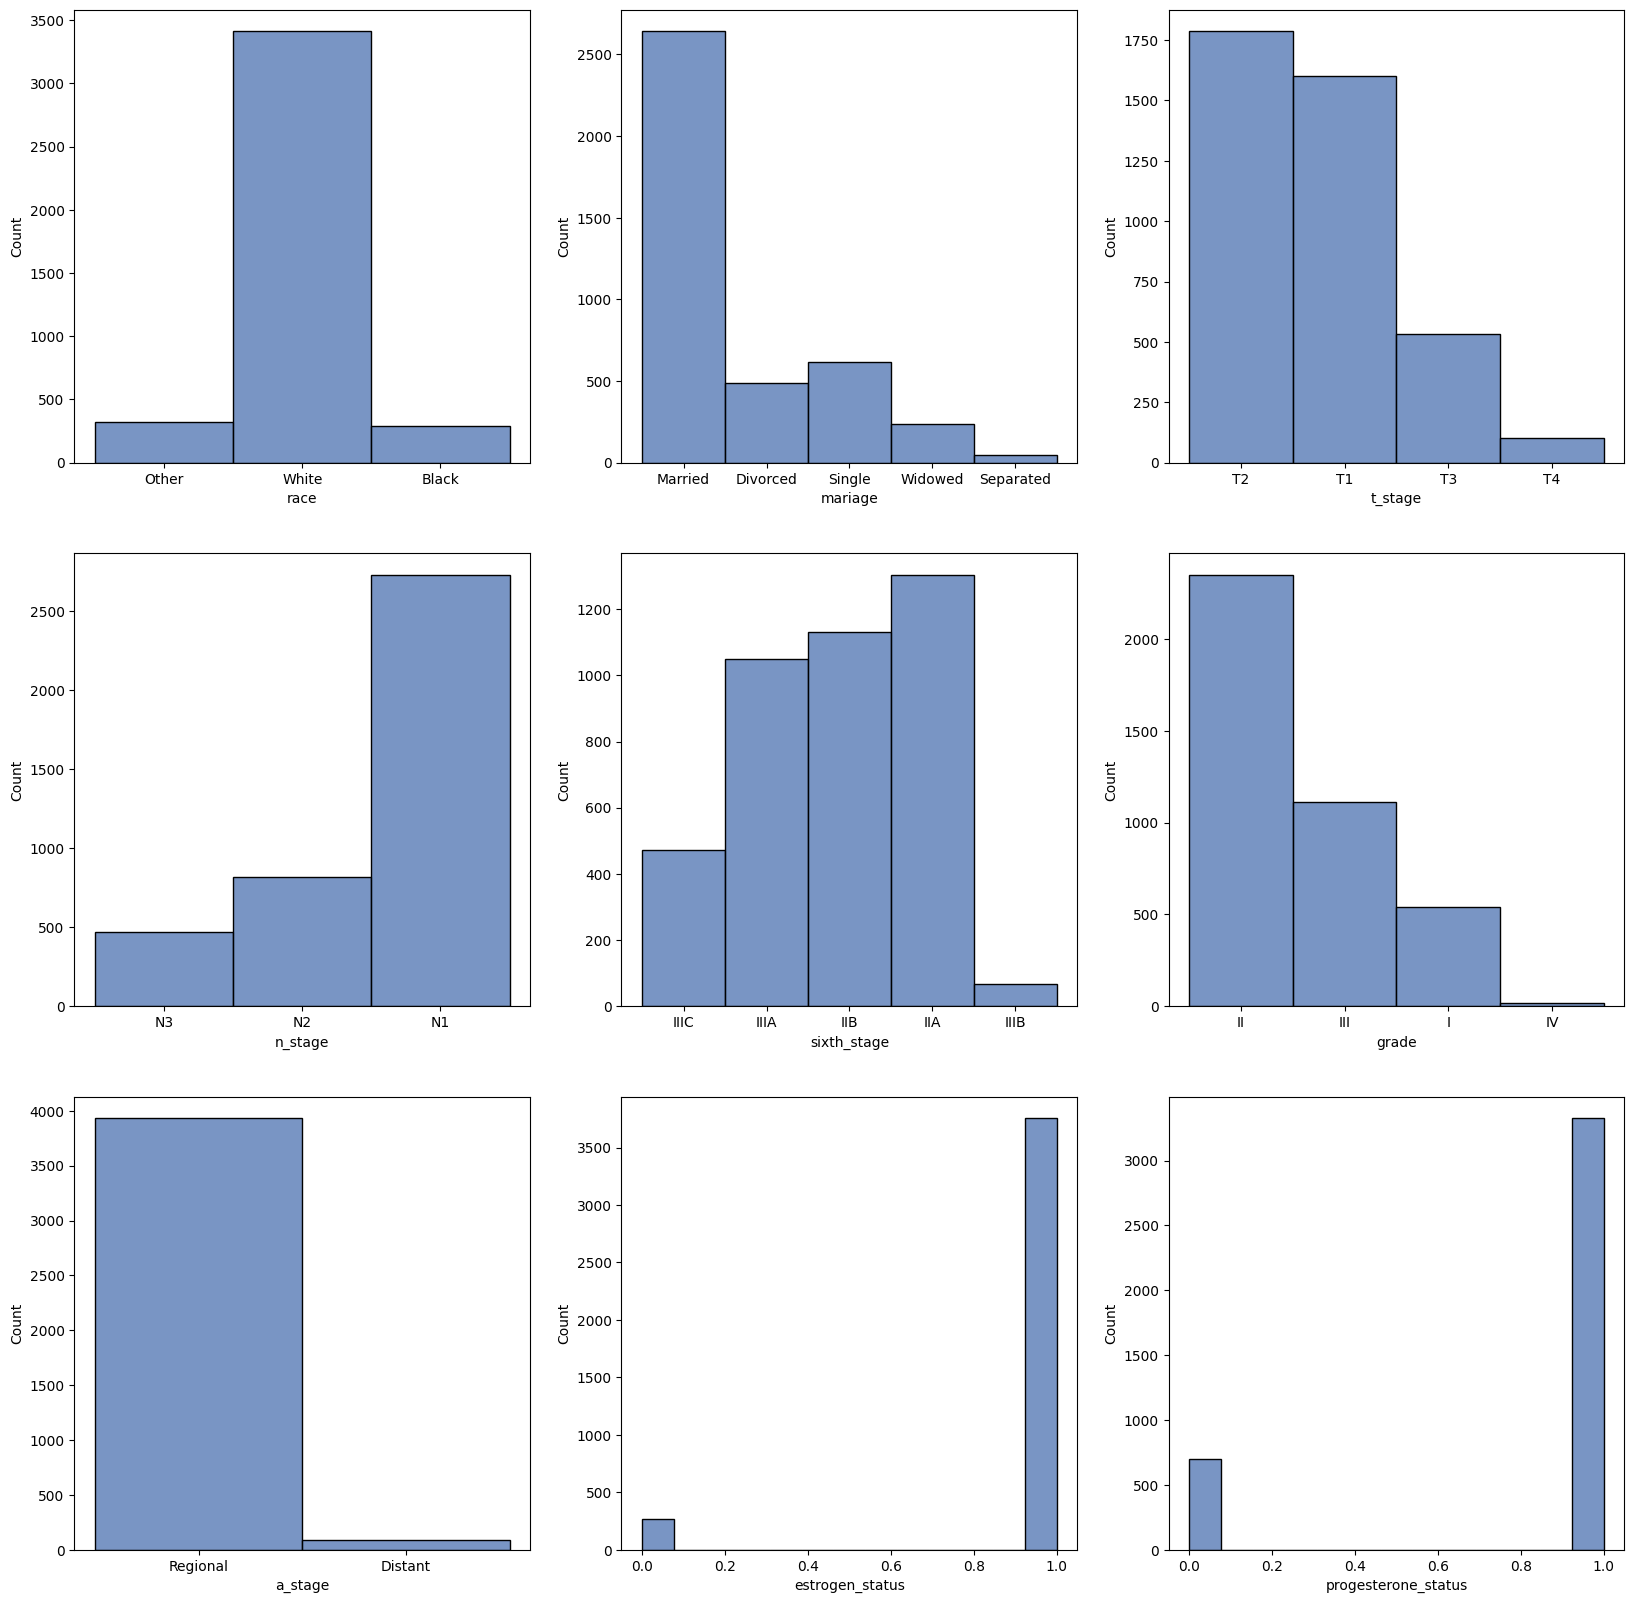

In [12]:
fig, ax = plt.subplots(3, 3, figsize=(20,20))
for i, axs in enumerate(ax.flatten()):
    sns.histplot(cancer_data[categorical_features[i]], ax=axs)

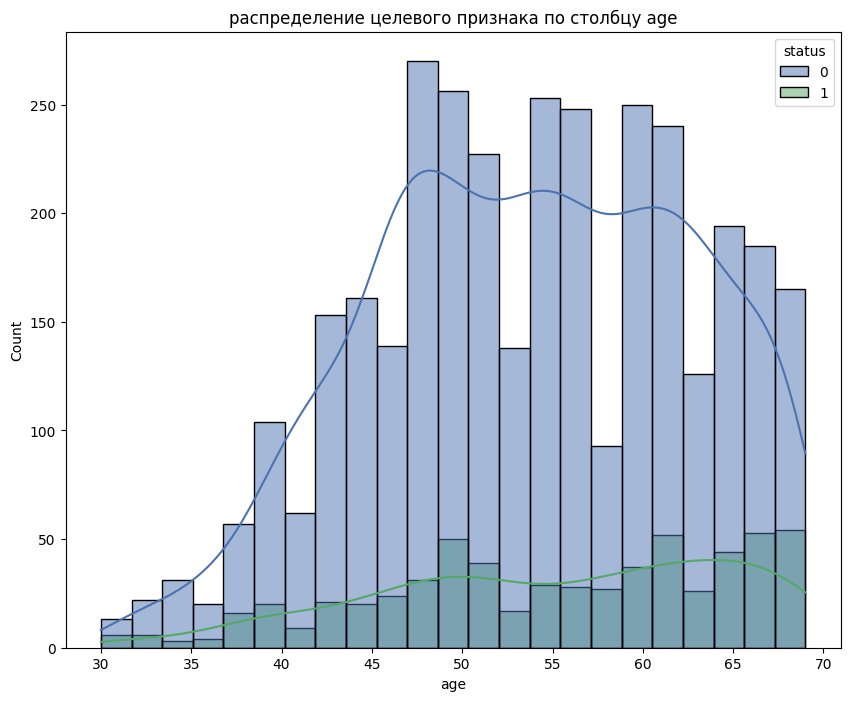

Описательные статистики по столбцу age в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,53.756384,8.808290,30.0,47.0,54.0,61.0,69.0
1,616.0,55.150974,9.698291,30.0,48.0,56.5,63.0,69.0


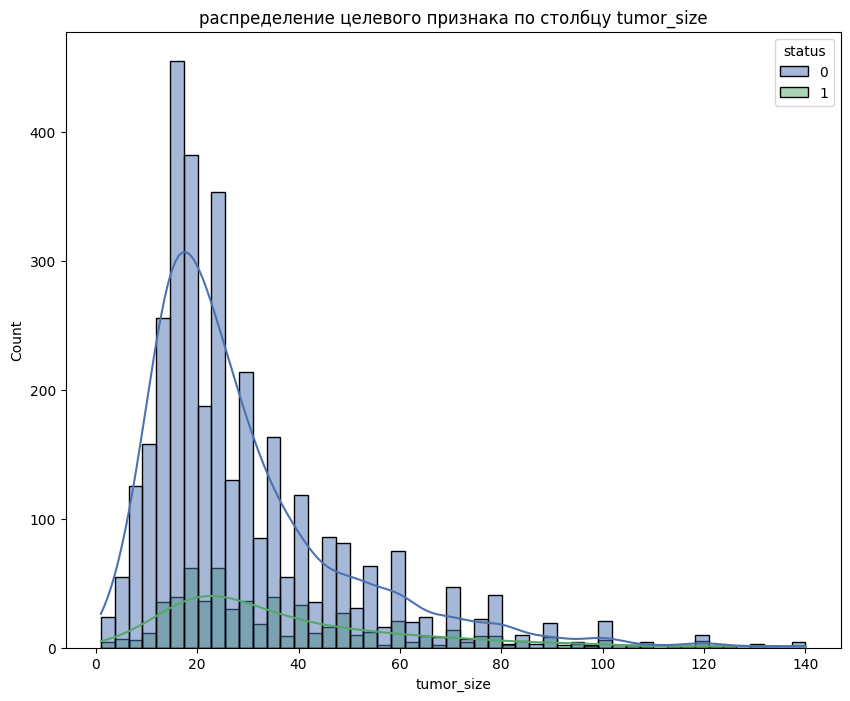

Описательные статистики по столбцу tumor_size в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,29.27238,20.305066,1.0,15.0,23.0,35.0,140.0
1,616.0,37.13961,24.116115,1.0,20.0,30.0,50.0,140.0


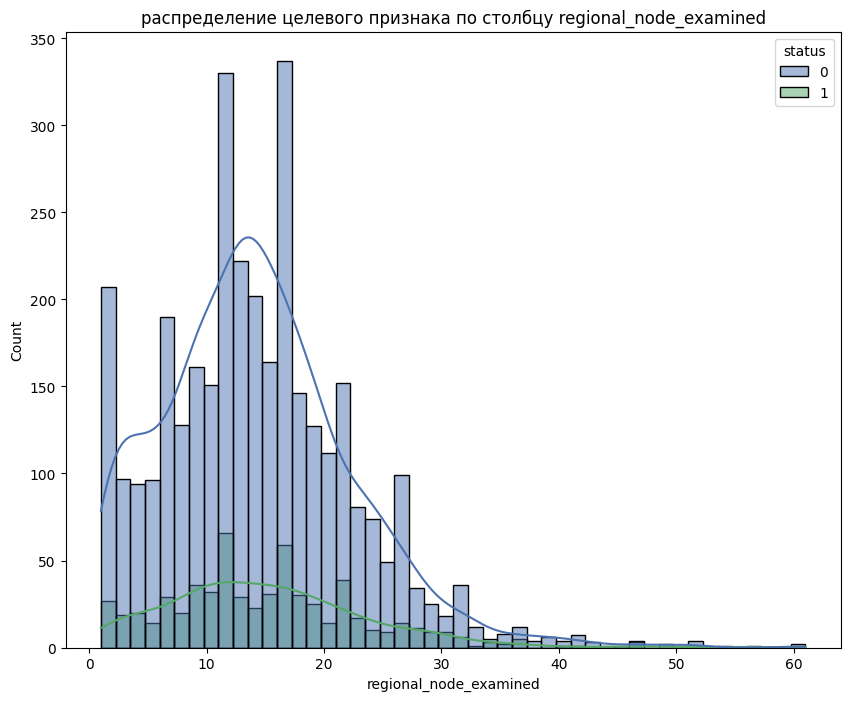

Описательные статистики по столбцу regional_node_examined в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,14.238920,8.023884,1.0,9.0,14.0,19.0,61.0
1,616.0,15.019481,8.486600,1.0,9.0,14.0,20.0,57.0


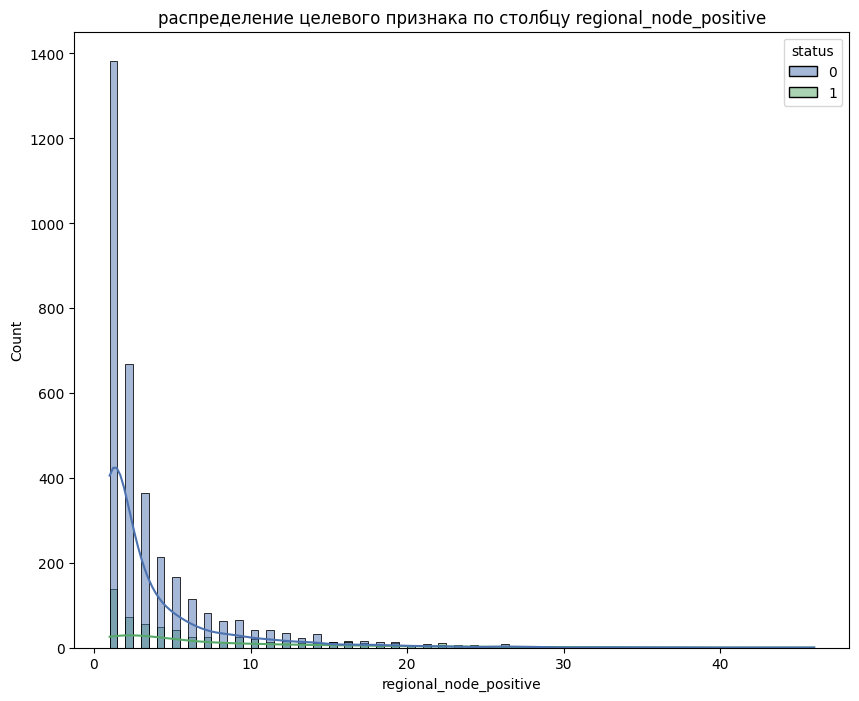

Описательные статистики по столбцу regional_node_positive в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,3.601409,4.375595,1.0,1.0,2.0,4.0,41.0
1,616.0,7.241883,7.312642,1.0,2.0,4.0,10.0,46.0


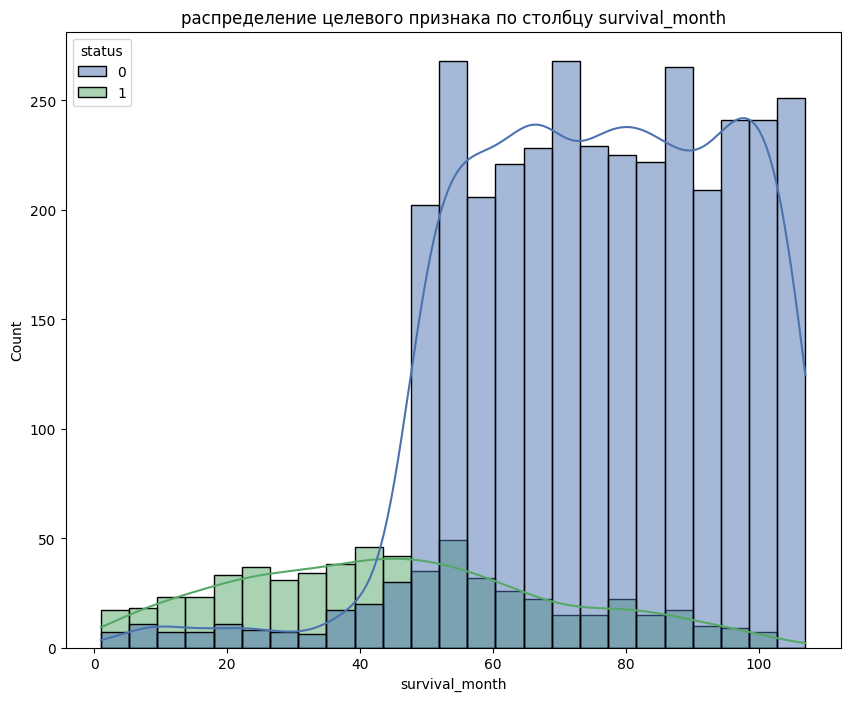

Описательные статистики по столбцу survival_month в зависимости от статуса


,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
0,3407.0,75.946874,19.386293,1.0,61.0,77.0,92.0,107.0
1,616.0,45.610390,23.966253,2.0,27.0,44.0,61.0,102.0


In [13]:
for i, feature in enumerate(numerical_features):
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    sns.histplot(
        data=cancer_data, 
        x=feature, 
        ax=ax, 
        hue='status',
        kde=True
    )
    ax.set_title(f"распределение целевого признака по столбцу {feature}")
    plt.show()
    print(f"Описательные статистики по столбцу {feature} в зависимости от статуса")
    display(
        cancer_data.groupby('status')[feature].describe()
    )

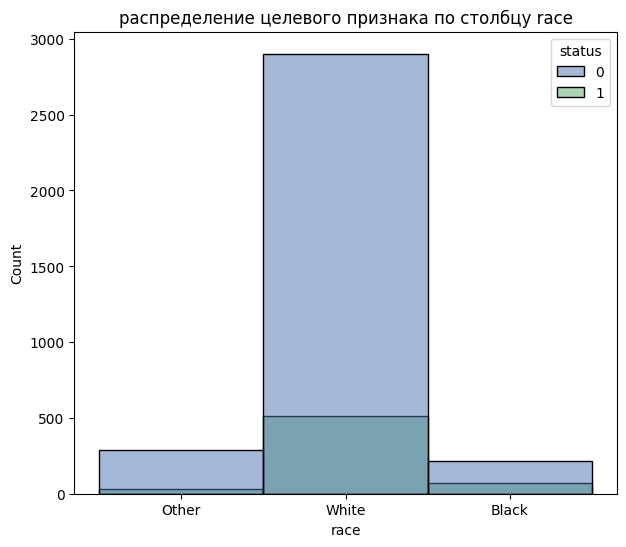

Распределение целевой пременной в зависимости от race


race   status
Black  0          218
       1           73
Other  0          287
       1           33
White  0         2902
       1          510
Name: status, dtype: int64

Распределение целевой пременной в зависимости от race в процентах


race   status
Black  0         0.749141
       1         0.250859
Other  0         0.896875
       1         0.103125
White  0         0.850528
       1         0.149472
Name: status, dtype: float64

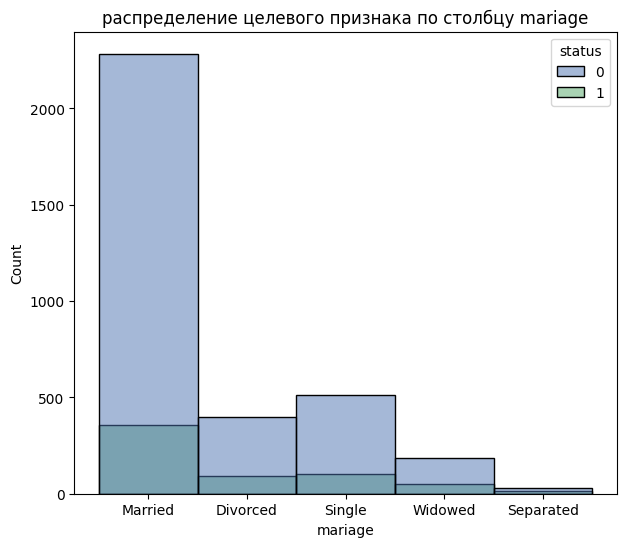

Распределение целевой пременной в зависимости от mariage


mariage    status
Divorced   0          396
           1           90
Married    0         2284
           1          358
Separated  0           30
           1           15
Single     0          511
           1          104
Widowed    0          186
           1           49
Name: status, dtype: int64

Распределение целевой пременной в зависимости от mariage в процентах


mariage    status
Divorced   0         0.814815
           1         0.185185
Married    0         0.864497
           1         0.135503
Separated  0         0.666667
           1         0.333333
Single     0         0.830894
           1         0.169106
Widowed    0         0.791489
           1         0.208511
Name: status, dtype: float64

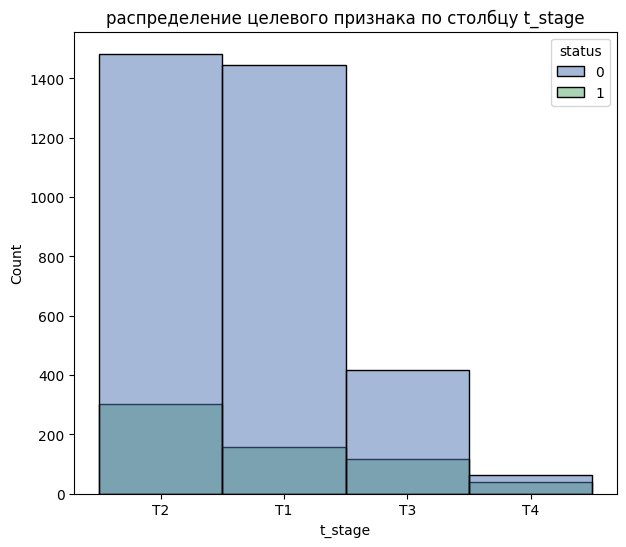

Распределение целевой пременной в зависимости от t_stage


t_stage  status
T1       0         1445
         1          157
T2       0         1483
         1          303
T3       0          417
         1          116
T4       0           62
         1           40
Name: status, dtype: int64

Распределение целевой пременной в зависимости от t_stage в процентах


t_stage  status
T1       0         0.901998
         1         0.098002
T2       0         0.830347
         1         0.169653
T3       0         0.782364
         1         0.217636
T4       0         0.607843
         1         0.392157
Name: status, dtype: float64

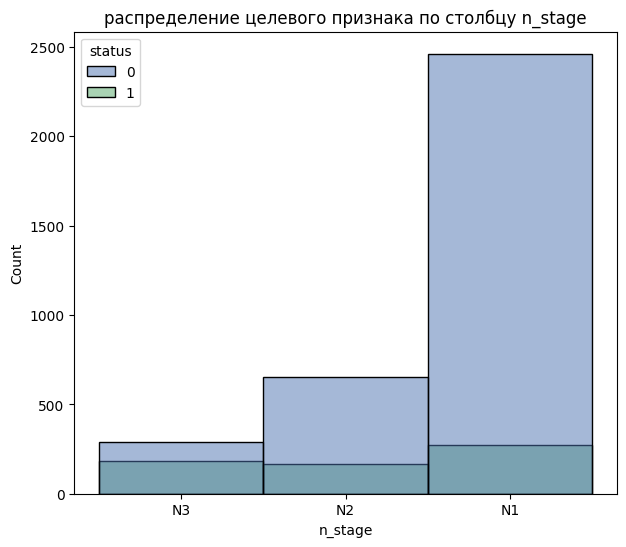

Распределение целевой пременной в зависимости от n_stage


n_stage  status
N1       0         2461
         1          270
N2       0          655
         1          165
N3       0          291
         1          181
Name: status, dtype: int64

Распределение целевой пременной в зависимости от n_stage в процентах


n_stage  status
N1       0         0.901135
         1         0.098865
N2       0         0.798780
         1         0.201220
N3       0         0.616525
         1         0.383475
Name: status, dtype: float64

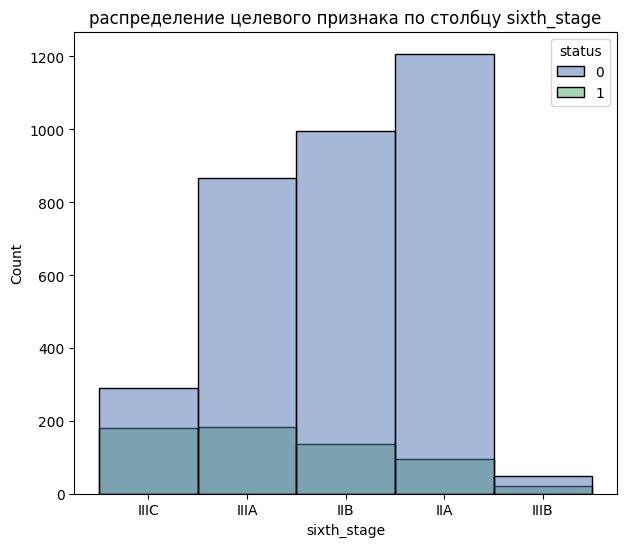

Распределение целевой пременной в зависимости от sixth_stage


sixth_stage  status
IIA          0         1208
             1           96
IIB          0          995
             1          135
IIIA         0          866
             1          184
IIIB         0           47
             1           20
IIIC         0          291
             1          181
Name: status, dtype: int64

Распределение целевой пременной в зависимости от sixth_stage в процентах


sixth_stage  status
IIA          0         0.926380
             1         0.073620
IIB          0         0.880531
             1         0.119469
IIIA         0         0.824762
             1         0.175238
IIIB         0         0.701493
             1         0.298507
IIIC         0         0.616525
             1         0.383475
Name: status, dtype: float64

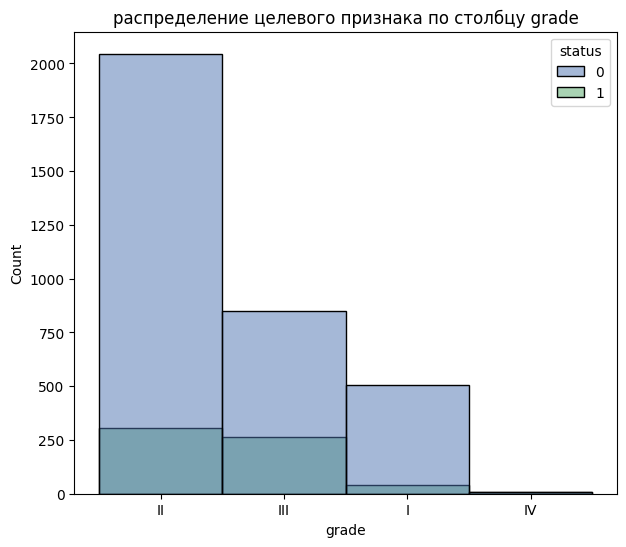

Распределение целевой пременной в зависимости от grade


grade  status
I      0          504
       1           39
II     0         2045
       1          305
III    0          848
       1          263
IV     0           10
       1            9
Name: status, dtype: int64

Распределение целевой пременной в зависимости от grade в процентах


grade  status
I      0         0.928177
       1         0.071823
II     0         0.870213
       1         0.129787
III    0         0.763276
       1         0.236724
IV     0         0.526316
       1         0.473684
Name: status, dtype: float64

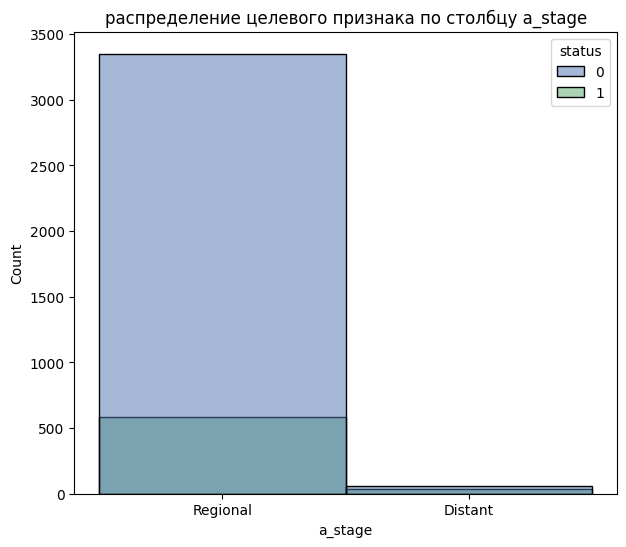

Распределение целевой пременной в зависимости от a_stage


a_stage   status
Distant   0           57
          1           35
Regional  0         3350
          1          581
Name: status, dtype: int64

Распределение целевой пременной в зависимости от a_stage в процентах


a_stage   status
Distant   0         0.619565
          1         0.380435
Regional  0         0.852200
          1         0.147800
Name: status, dtype: float64

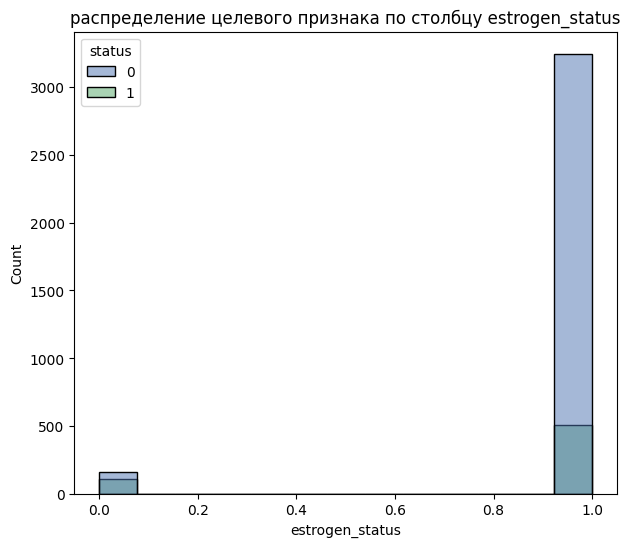

Распределение целевой пременной в зависимости от estrogen_status


estrogen_status  status
0                0          161
                 1          108
1                0         3246
                 1          508
Name: status, dtype: int64

Распределение целевой пременной в зависимости от estrogen_status в процентах


estrogen_status  status
0                0         0.598513
                 1         0.401487
1                0         0.864678
                 1         0.135322
Name: status, dtype: float64

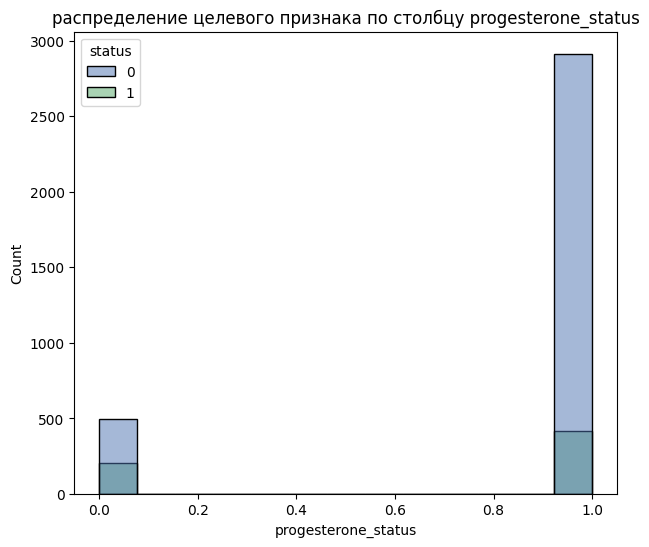

Распределение целевой пременной в зависимости от progesterone_status


progesterone_status  status
0                    0          494
                     1          204
1                    0         2913
                     1          412
Name: status, dtype: int64

Распределение целевой пременной в зависимости от progesterone_status в процентах


progesterone_status  status
0                    0         0.707736
                     1         0.292264
1                    0         0.876090
                     1         0.123910
Name: status, dtype: float64

In [14]:
for i, feature in enumerate(categorical_features):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    sns.histplot(data=cancer_data, 
                 x=feature, 
                 ax=ax, 
                 hue='status'
                )
    ax.set_title(f"распределение целевого признака по столбцу {feature}")
    plt.show()
    print(f"Распределение целевой пременной в зависимости от {feature}")
    display(
        cancer_data.groupby(feature)['status'].value_counts()
    )
    print(f"Распределение целевой пременной в зависимости от {feature} в процентах")
    display(
        cancer_data.groupby(feature)['status'].value_counts() / cancer_data.groupby(feature)['status'].count()
    )

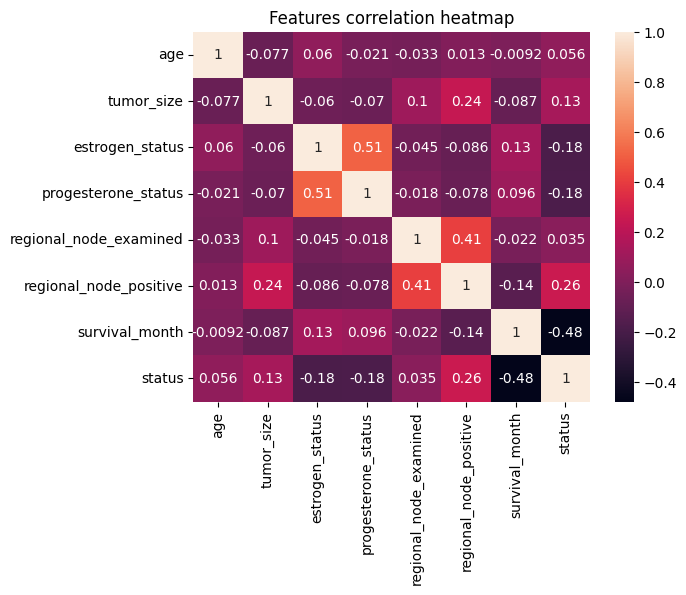

In [15]:
ax = sns.heatmap(
    cancer_data.corr(numeric_only=True), 
    annot=True,
)
ax.set_title("Features correlation heatmap")
None

***Looks like we dont have high-correlated features, so we don't need to drop any column***

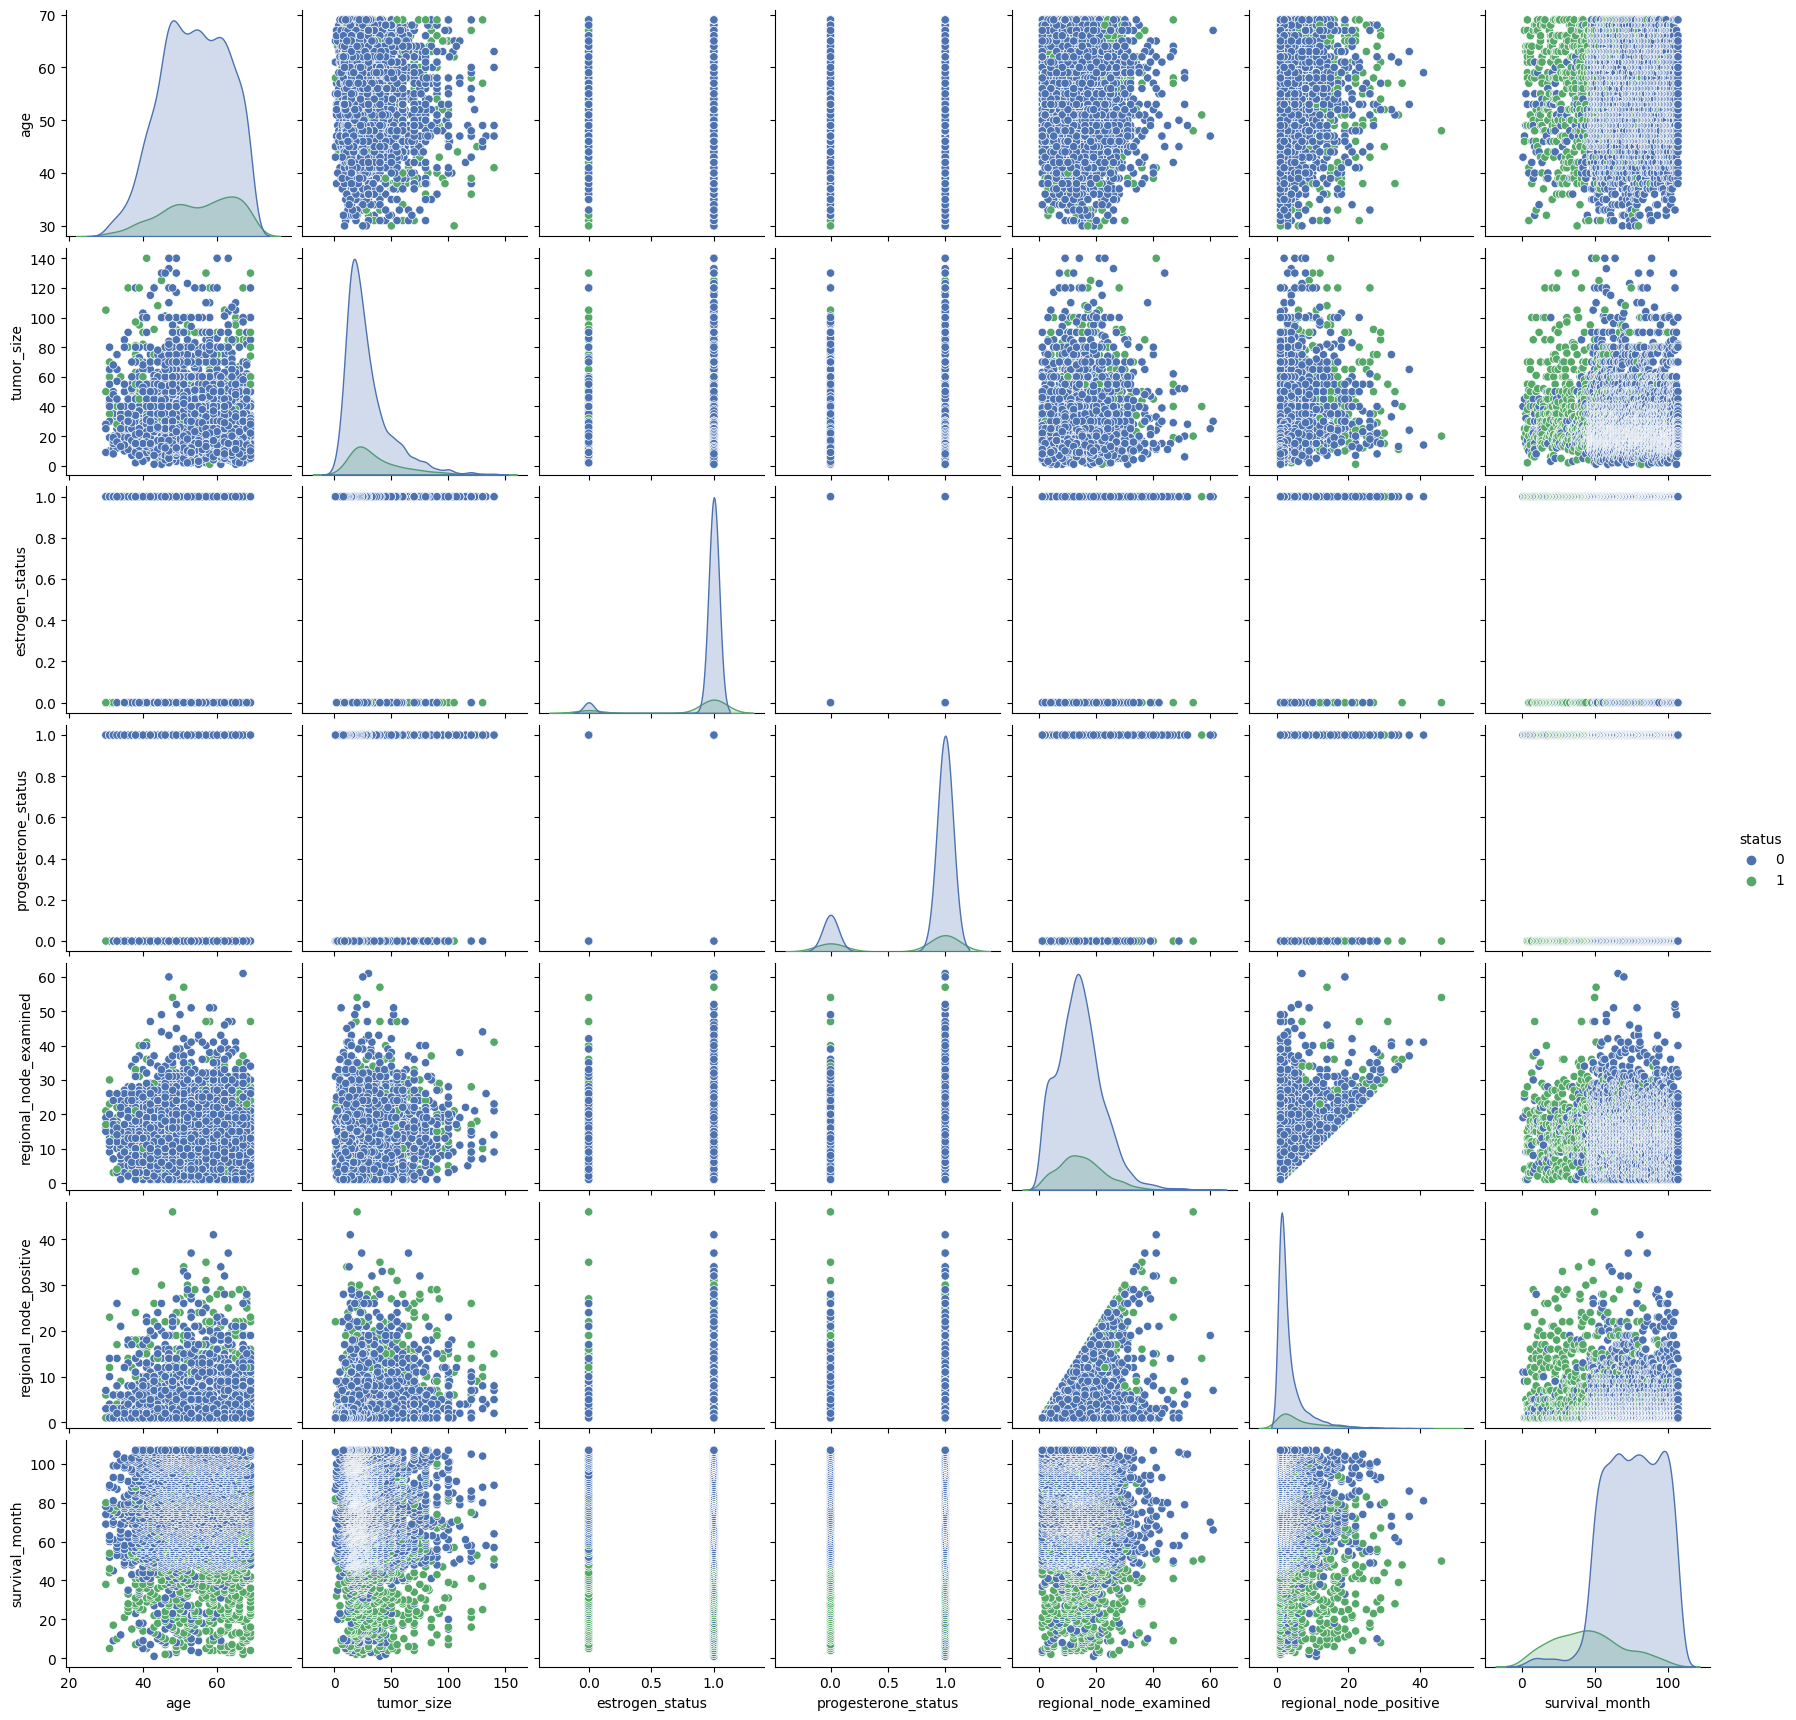

In [16]:
sns.pairplot(data=cancer_data, hue='status')

### EDA summary
1) Chance of surviving highly depends on survival month.  
After research I found that it's calculating like this:  
FLOOR((endpoint – date of diagnosis) / days in a month).  
So basicaly if women was late with diagnostics and, unfortunatley died, this feature will show it.  
Therefore it will not be used for modeling, because it can lead to data leakage.  
2) Women with higher age have more chances to die of breast cancer.  
3) After little research I found that if progesteron and estrogen status is negative cancer if much harder to treat, 
It is shown in this data analisys, because procent of alive women with negative estrogen and progesterone status is lower than with positive. We'll probably need one more column that will discribe both negative estrogen and negative progesterone.

In [17]:
cancer_data["progesterone_estrogen"] = cancer_data.progesterone_status & cancer_data.estrogen_status

In [18]:
cancer_data.corr(numeric_only=True)["progesterone_estrogen"]

age                      -0.012686
tumor_size               -0.072642
estrogen_status           0.570933
progesterone_status       0.977211
regional_node_examined   -0.018615
regional_node_positive   -0.077067
survival_month            0.093698
status                   -0.177772
progesterone_estrogen     1.000000
Name: progesterone_estrogen, dtype: float64

**It has very high correlation with progesterone status, so I'll drop it along with survival_month column**

In [19]:
cancer_data = cancer_data.drop(['progesterone_estrogen', 'survival_month'], axis=1)

*Thats how our data looks after eda*

In [20]:
cancer_data.head(5)

,age,race,mariage,t_stage,n_stage,sixth_stage,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive,status
0,43,Other,Married,T2,N3,IIIC,II,Regional,40,1,1,19,11,0
1,47,Other,Married,T2,N2,IIIA,II,Regional,45,1,1,25,9,0
2,67,White,Married,T2,N1,IIB,III,Regional,25,1,1,4,1,1
3,46,White,Divorced,T1,N1,IIA,II,Regional,19,1,1,26,1,1
4,63,White,Married,T2,N2,IIIA,II,Regional,35,1,1,21,5,1


# Models

* As a metric we could use *Recall* as it will lower probability of us misclassifying probable death and doctors can make some desperate decisions in order to safe one's life.   
* For dealing with unbalanced data we'll use several techniques and compare them to modeling with unbalanced classes:
    * **ADASYN**
    * **SMOTE**  
* As a model we'll use random forest, logistic regresion and different types of boosting(catboost and xgboost). Also we could use neural networks, but there are too few data to properly train them.

In [404]:
# imports for ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# fixing unbalanced
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC

# boostings
from catboost import CatBoostClassifier, Pool
from catboost.metrics import Recall, Precision

from xgboost import XGBClassifier

In [22]:
X, y = cancer_data.drop('status', axis=1), cancer_data.status

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=y
                                               )

In [33]:
numerical_features = [
    'age',
    'tumor_size',
    'regional_node_examined',
    'regional_node_positive',
    'estrogen_status',
    'progesterone_status'
]
categorical_features = [
    'race',
    'mariage',
    't_stage',
    'n_stage',
    'sixth_stage',
    'grade',
    'a_stage'
]

## 1. Unbalanced classes

In [203]:
# Data pipelines
numeric_transformer = Pipeline(steps=[
    ('scaling', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoding', OneHotEncoder())
])
data_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features)
])
preprocessor = Pipeline(steps=[('data_transformer', data_transformer)])
preprocessor

Pipeline(steps=[('data_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age', 'tumor_size',
                                                   'regional_node_examined',
                                                   'regional_node_positive',
                                                   'estrogen_status',
                                                   'progesterone_status']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder())]),
                                                  ['race', 'mariage', 't_stage',
                                                   'n_stage', 'sixth_stage',
                                                   'grade', 'a_stage'])]))])

### 1.  Logistic Regression

In [204]:
lr = LogisticRegression()
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', lr)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression())])

In [205]:
param_grid = {
    'classification__penalty' : ['none', 'l2'],
    'classification__C': np.arange(0.1, 2, 0.1)
}

In [206]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='recall', 
                  cv=5,
                  n_jobs=-1,
                  verbose=2
                 )
gs.fit(X_train, y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numeric',
                                                                                          Pipeline(steps=[('scaling',
                                                                                                           StandardScaler())]),
                                                                                          ['age',
                                                                                           'tumor_size',
                                                                                           'regional_node_examined',
                                                                                           'regional_node_positive',
                                                                                           'estrogen_status',
                                                                                           'progesterone_status']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('encoding',
                                                                                                           OneHotEncoder())]),
                                                                                          ['race',
                                                                                           'mariage',
                                                                                           't_stage',
                                                                                           'n_stage',
                                                                                           'sixth_stage',
                                                                                           'grade',
                                                                                           'a_stage'])]))])),
                                       ('classification',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classification__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'classification__penalty': ['none', 'l2']},
             scoring='recall', verbose=2)

In [207]:
gs.best_score_

0.14811379097093383

In [208]:
gs.best_params_

{'classification__C': 0.2, 'classification__penalty': 'l2'}

**Actual Model**

In [209]:
lr = LogisticRegression(C= 0.2, penalty='l2')
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', lr)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression(C=0.2))])

In [219]:
model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression(C=0.2))])

In [220]:
results = model.predict(X_test)

In [221]:
def display_confusion_matrix(y_true, y_predicted):
    true_pos = y_true[y_true == y_predicted][y_true == 1].count()
    true_neg = y_true[y_true == y_predicted][y_true == 0].count()
    false_pos = y_true[y_true != y_predicted][y_true == 1].count()
    false_neg = y_true[y_true != y_predicted][y_true == 0].count()
    cm = np.array([[true_pos, false_pos],[false_neg, true_neg]])
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    sns.heatmap(cm, 
                annot=True, 
                fmt='g',
                cbar=False, 
                xticklabels=['P', 'N'], 
                yticklabels=['P', 'N'],
                cmap='Blues',
                ax=ax[0]
               )
    sns.heatmap(cm / cm.sum(), 
                annot=True, 
                fmt='.2%',
                cbar=False, 
                xticklabels=['P', 'N'], 
                yticklabels=['P', 'N'],
                cmap='Blues',
                ax=ax[1]
               )
    fig.suptitle("Confusion matrices")
    ax[0].set_title("absolute values")
    ax[0].set_xlabel("predicted labels")
    ax[0].set_ylabel("actual labels")
    ax[1].set_title("percentages")
    ax[1].set_xlabel("predicted labels")
    ax[1].set_ylabel("actual labels")
    plt.show()

    print(f'accuracy = {accuracy_score(y_true, y_predicted)}')
    print(f'precision = {precision_score(y_true, y_predicted)}')
    print(f'recall = {recall_score(y_true, y_predicted)}')

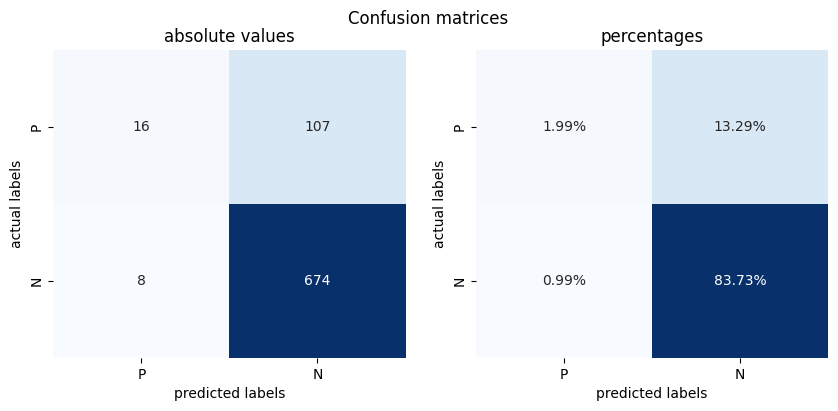

accuracy = 0.8571428571428571
precision = 0.6666666666666666
recall = 0.13008130081300814


In [222]:
display_confusion_matrix(y_test, results)

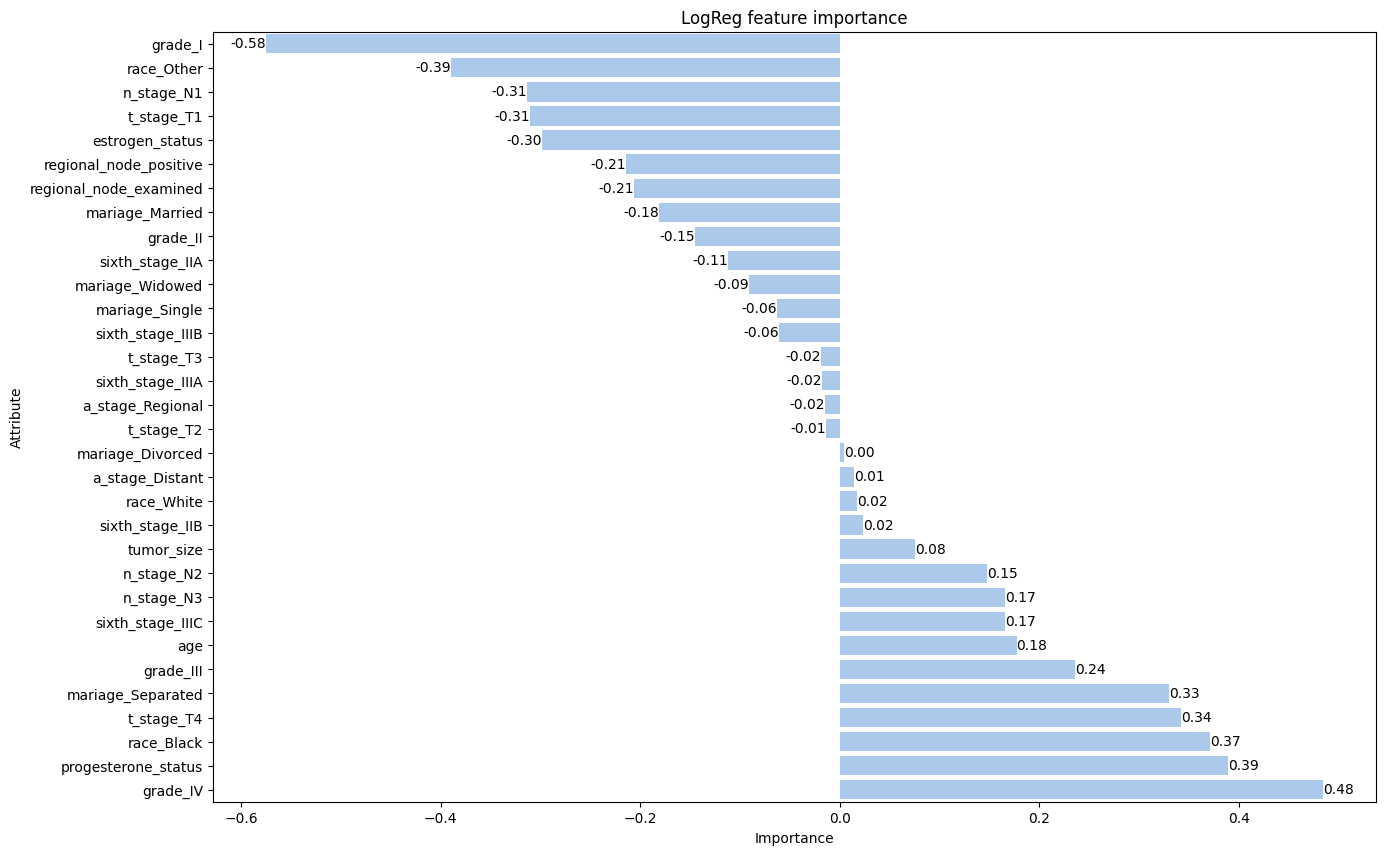

In [268]:
feature_importance = pd.DataFrame(data={
    'Attribute': pd.get_dummies(X_train).columns,
    'Importance': model.named_steps.classification.coef_[0]
})
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.set_color_codes("pastel")
ax = sns.barplot(feature_importance.sort_values(by='Importance'), 
            y='Attribute', 
            x='Importance', 
            color="b",
           )
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_title("LogReg feature importance")
None

## 2. RandomForest

In [272]:
rf = RandomForestClassifier()
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', rf)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier())])

In [281]:
param_grid = {
    'classification__n_estimators' : [300, 500, 700, 900, 1100],
    'classification__max_depth' : [3, 4, 5, None],
    'classification__min_samples_leaf' : [1, 2, 4],
    'classification__bootstrap': [True],
}

In [282]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='recall', 
                  cv=5,
                  n_jobs=-1,
                  verbose=10
                 )
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numeric',
                                                                                          Pipeline(steps=[('scaling',
                                                                                                           StandardScaler())]),
                                                                                          ['age',
                                                                                           'tumor_size',
                                                                                           'regional_node_examined',
                                                                                           'regional_node_positive',
                                                                                           'estrogen_status',
                                                                                           'progesterone_status']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('encoding',
                                                                                                           OneHotEncoder())]),
                                                                                          ['race',
                                                                                           'mariage',
                                                                                           't_stage',
                                                                                           'n_stage',
                                                                                           'sixth_stage',
                                                                                           'grade',
                                                                                           'a_stage'])]))])),
                                       ('classification',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classification__bootstrap': [True],
                         'classification__max_depth': [3, 4, 5, None],
                         'classification__min_samples_leaf': [1, 2, 4],
                         'classification__n_estimators': [300, 500, 700, 900,
                                                          1100]},
             scoring='recall', verbose=10)

In [283]:
gs.best_score_

0.146031746031746

In [284]:
gs.best_params_

{'classification__bootstrap': True,
 'classification__max_depth': None,
 'classification__min_samples_leaf': 1,
 'classification__n_estimators': 900}

Actual model

In [302]:
rf = RandomForestClassifier(n_estimators=900, bootstrap=True, max_depth=None, min_samples_leaf=1)
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', rf)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier(n_estimators=900))])

In [303]:
model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier(n_estimators=900))])

In [304]:
y_pred = model.predict(X_test)

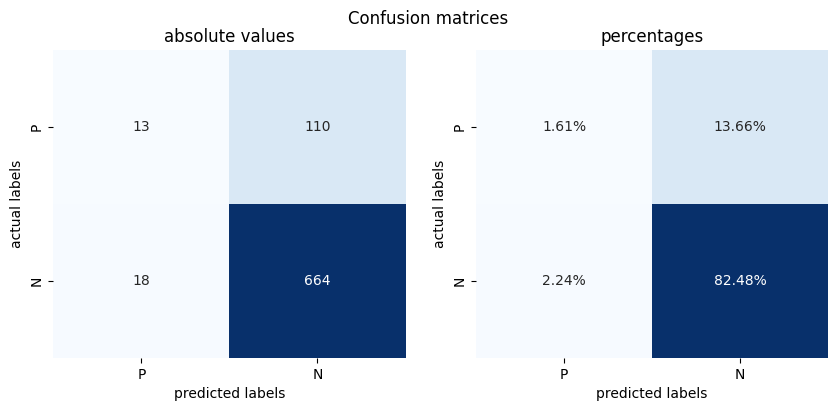

accuracy = 0.8409937888198757
precision = 0.41935483870967744
recall = 0.10569105691056911


In [305]:
display_confusion_matrix(y_test, y_pred)

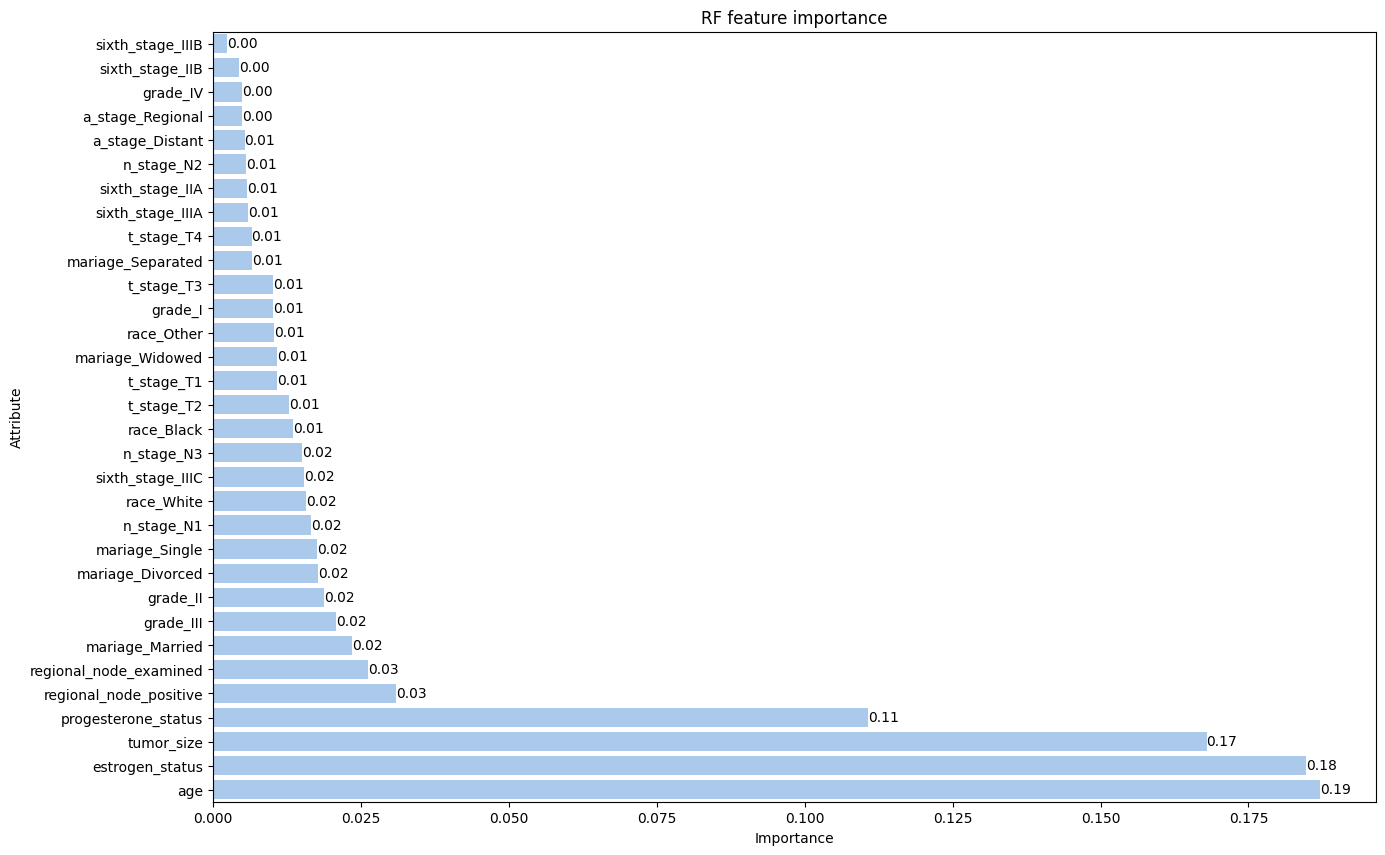

In [308]:
feature_importance = pd.DataFrame(data={
    'Attribute': pd.get_dummies(X_train).columns,
    'Importance': model.named_steps.classification.feature_importances_
})
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.set_color_codes("pastel")
ax = sns.barplot(feature_importance.sort_values(by='Importance'), 
            y='Attribute', 
            x='Importance', 
            color="b",
           )
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_title("RF feature importance")
None

CATBOOST

In [321]:
model = CatBoostClassifier(learning_rate=0.04,
                           custom_metric=['Recall'])

In [386]:
cdata_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numerical_features),
    ('cat', 'passthrough', categorical_features)
])

#[(lambda x: x.replace('numeric__', '').replace('cat__', ''))(x) for x in (cdata_transformer.get_feature_names_out())])
cX_train = pd.DataFrame(cdata_transformer.fit_transform(X_train), columns=numerical_features + categorical_features)
cX_test = pd.DataFrame(cdata_transformer.fit_transform(X_test), columns=numerical_features + categorical_features)

In [387]:
test_cat_data = Pool(cX_test, y_test, cat_features=categorical_features)

model.fit(cX_train,
          y_train,
          eval_set=test_cat_data,
          verbose=True, cat_features=categorical_features)

0:	learn: 0.6677584	test: 0.6676192	best: 0.6676192 (0)	total: 42.7ms	remaining: 42.7s
1:	learn: 0.6453559	test: 0.6452175	best: 0.6452175 (1)	total: 55.9ms	remaining: 27.9s
2:	learn: 0.6227706	test: 0.6223571	best: 0.6223571 (2)	total: 77ms	remaining: 25.6s
3:	learn: 0.6016797	test: 0.6015113	best: 0.6015113 (3)	total: 124ms	remaining: 30.8s
4:	learn: 0.5812797	test: 0.5812733	best: 0.5812733 (4)	total: 147ms	remaining: 29.2s
5:	learn: 0.5642958	test: 0.5645694	best: 0.5645694 (5)	total: 168ms	remaining: 27.8s
6:	learn: 0.5472350	test: 0.5479978	best: 0.5479978 (6)	total: 189ms	remaining: 26.9s
7:	learn: 0.5357144	test: 0.5364859	best: 0.5364859 (7)	total: 196ms	remaining: 24.3s
8:	learn: 0.5211622	test: 0.5219397	best: 0.5219397 (8)	total: 217ms	remaining: 23.9s
9:	learn: 0.5096505	test: 0.5104775	best: 0.5104775 (9)	total: 232ms	remaining: 23s
10:	learn: 0.4982067	test: 0.4990794	best: 0.4990794 (10)	total: 253ms	remaining: 22.8s
11:	learn: 0.4886388	test: 0.4897332	best: 0.4897332 

97:	learn: 0.3482527	test: 0.3732180	best: 0.3732180 (97)	total: 2.19s	remaining: 20.1s
98:	learn: 0.3478999	test: 0.3730384	best: 0.3730384 (98)	total: 2.21s	remaining: 20.1s
99:	learn: 0.3476544	test: 0.3728842	best: 0.3728842 (99)	total: 2.24s	remaining: 20.1s
100:	learn: 0.3472672	test: 0.3727945	best: 0.3727945 (100)	total: 2.26s	remaining: 20.1s
101:	learn: 0.3471174	test: 0.3728777	best: 0.3727945 (100)	total: 2.29s	remaining: 20.2s
102:	learn: 0.3468670	test: 0.3728521	best: 0.3727945 (100)	total: 2.31s	remaining: 20.2s
103:	learn: 0.3463783	test: 0.3726974	best: 0.3726974 (103)	total: 2.34s	remaining: 20.2s
104:	learn: 0.3459593	test: 0.3727198	best: 0.3726974 (103)	total: 2.36s	remaining: 20.1s
105:	learn: 0.3458936	test: 0.3727115	best: 0.3726974 (103)	total: 2.38s	remaining: 20s
106:	learn: 0.3458213	test: 0.3727022	best: 0.3726974 (103)	total: 2.4s	remaining: 20s
107:	learn: 0.3456702	test: 0.3724955	best: 0.3724955 (107)	total: 2.43s	remaining: 20.1s
108:	learn: 0.3452551

198:	learn: 0.3245215	test: 0.3706659	best: 0.3704187 (151)	total: 4.62s	remaining: 18.6s
199:	learn: 0.3245208	test: 0.3706592	best: 0.3704187 (151)	total: 4.63s	remaining: 18.5s
200:	learn: 0.3244208	test: 0.3706557	best: 0.3704187 (151)	total: 4.66s	remaining: 18.5s
201:	learn: 0.3241555	test: 0.3706972	best: 0.3704187 (151)	total: 4.68s	remaining: 18.5s
202:	learn: 0.3237418	test: 0.3709711	best: 0.3704187 (151)	total: 4.7s	remaining: 18.5s
203:	learn: 0.3234199	test: 0.3710935	best: 0.3704187 (151)	total: 4.72s	remaining: 18.4s
204:	learn: 0.3233227	test: 0.3711425	best: 0.3704187 (151)	total: 4.75s	remaining: 18.4s
205:	learn: 0.3233020	test: 0.3710996	best: 0.3704187 (151)	total: 4.77s	remaining: 18.4s
206:	learn: 0.3230702	test: 0.3712002	best: 0.3704187 (151)	total: 4.79s	remaining: 18.4s
207:	learn: 0.3229475	test: 0.3711760	best: 0.3704187 (151)	total: 4.82s	remaining: 18.3s
208:	learn: 0.3226536	test: 0.3711078	best: 0.3704187 (151)	total: 4.84s	remaining: 18.3s
209:	learn:

297:	learn: 0.3013960	test: 0.3727152	best: 0.3703323 (229)	total: 7.02s	remaining: 16.5s
298:	learn: 0.3013590	test: 0.3727118	best: 0.3703323 (229)	total: 7.05s	remaining: 16.5s
299:	learn: 0.3011389	test: 0.3728184	best: 0.3703323 (229)	total: 7.07s	remaining: 16.5s
300:	learn: 0.3009188	test: 0.3726926	best: 0.3703323 (229)	total: 7.09s	remaining: 16.5s
301:	learn: 0.3008494	test: 0.3726951	best: 0.3703323 (229)	total: 7.12s	remaining: 16.4s
302:	learn: 0.3006014	test: 0.3727779	best: 0.3703323 (229)	total: 7.14s	remaining: 16.4s
303:	learn: 0.3005070	test: 0.3727551	best: 0.3703323 (229)	total: 7.16s	remaining: 16.4s
304:	learn: 0.3002930	test: 0.3728774	best: 0.3703323 (229)	total: 7.18s	remaining: 16.4s
305:	learn: 0.3001656	test: 0.3729141	best: 0.3703323 (229)	total: 7.21s	remaining: 16.3s
306:	learn: 0.3001020	test: 0.3729138	best: 0.3703323 (229)	total: 7.24s	remaining: 16.3s
307:	learn: 0.3000677	test: 0.3729106	best: 0.3703323 (229)	total: 7.26s	remaining: 16.3s
308:	learn

395:	learn: 0.2820302	test: 0.3746788	best: 0.3703323 (229)	total: 9.42s	remaining: 14.4s
396:	learn: 0.2817949	test: 0.3746976	best: 0.3703323 (229)	total: 9.45s	remaining: 14.3s
397:	learn: 0.2816859	test: 0.3746771	best: 0.3703323 (229)	total: 9.47s	remaining: 14.3s
398:	learn: 0.2816164	test: 0.3746540	best: 0.3703323 (229)	total: 9.49s	remaining: 14.3s
399:	learn: 0.2814603	test: 0.3749648	best: 0.3703323 (229)	total: 9.51s	remaining: 14.3s
400:	learn: 0.2812737	test: 0.3750902	best: 0.3703323 (229)	total: 9.54s	remaining: 14.2s
401:	learn: 0.2810162	test: 0.3751409	best: 0.3703323 (229)	total: 9.56s	remaining: 14.2s
402:	learn: 0.2809549	test: 0.3751518	best: 0.3703323 (229)	total: 9.58s	remaining: 14.2s
403:	learn: 0.2807333	test: 0.3750620	best: 0.3703323 (229)	total: 9.6s	remaining: 14.2s
404:	learn: 0.2804936	test: 0.3750215	best: 0.3703323 (229)	total: 9.63s	remaining: 14.1s
405:	learn: 0.2804060	test: 0.3750447	best: 0.3703323 (229)	total: 9.65s	remaining: 14.1s
406:	learn:

492:	learn: 0.2671709	test: 0.3791398	best: 0.3703323 (229)	total: 12s	remaining: 12.4s
493:	learn: 0.2670168	test: 0.3789484	best: 0.3703323 (229)	total: 12s	remaining: 12.3s
494:	learn: 0.2668551	test: 0.3789839	best: 0.3703323 (229)	total: 12.1s	remaining: 12.3s
495:	learn: 0.2666549	test: 0.3791257	best: 0.3703323 (229)	total: 12.1s	remaining: 12.3s
496:	learn: 0.2665314	test: 0.3790787	best: 0.3703323 (229)	total: 12.1s	remaining: 12.3s
497:	learn: 0.2663715	test: 0.3791295	best: 0.3703323 (229)	total: 12.1s	remaining: 12.2s
498:	learn: 0.2662232	test: 0.3790442	best: 0.3703323 (229)	total: 12.2s	remaining: 12.2s
499:	learn: 0.2661734	test: 0.3790486	best: 0.3703323 (229)	total: 12.2s	remaining: 12.2s
500:	learn: 0.2661171	test: 0.3790801	best: 0.3703323 (229)	total: 12.2s	remaining: 12.2s
501:	learn: 0.2660035	test: 0.3790855	best: 0.3703323 (229)	total: 12.2s	remaining: 12.1s
502:	learn: 0.2659017	test: 0.3790900	best: 0.3703323 (229)	total: 12.3s	remaining: 12.1s
503:	learn: 0.

592:	learn: 0.2530053	test: 0.3827182	best: 0.3703323 (229)	total: 16.2s	remaining: 11.1s
593:	learn: 0.2529739	test: 0.3827041	best: 0.3703323 (229)	total: 16.3s	remaining: 11.1s
594:	learn: 0.2528667	test: 0.3826718	best: 0.3703323 (229)	total: 16.3s	remaining: 11.1s
595:	learn: 0.2527183	test: 0.3827657	best: 0.3703323 (229)	total: 16.3s	remaining: 11.1s
596:	learn: 0.2526324	test: 0.3827018	best: 0.3703323 (229)	total: 16.3s	remaining: 11s
597:	learn: 0.2524675	test: 0.3827282	best: 0.3703323 (229)	total: 16.4s	remaining: 11s
598:	learn: 0.2524076	test: 0.3827561	best: 0.3703323 (229)	total: 16.4s	remaining: 11s
599:	learn: 0.2522844	test: 0.3828919	best: 0.3703323 (229)	total: 16.4s	remaining: 10.9s
600:	learn: 0.2521401	test: 0.3829155	best: 0.3703323 (229)	total: 16.4s	remaining: 10.9s
601:	learn: 0.2520638	test: 0.3829085	best: 0.3703323 (229)	total: 16.4s	remaining: 10.9s
602:	learn: 0.2519012	test: 0.3829982	best: 0.3703323 (229)	total: 16.5s	remaining: 10.8s
603:	learn: 0.25

687:	learn: 0.2396392	test: 0.3841611	best: 0.3703323 (229)	total: 18.9s	remaining: 8.56s
688:	learn: 0.2396002	test: 0.3841362	best: 0.3703323 (229)	total: 18.9s	remaining: 8.54s
689:	learn: 0.2394343	test: 0.3840231	best: 0.3703323 (229)	total: 18.9s	remaining: 8.51s
690:	learn: 0.2393589	test: 0.3840354	best: 0.3703323 (229)	total: 19s	remaining: 8.48s
691:	learn: 0.2393150	test: 0.3840311	best: 0.3703323 (229)	total: 19s	remaining: 8.46s
692:	learn: 0.2390482	test: 0.3841198	best: 0.3703323 (229)	total: 19s	remaining: 8.43s
693:	learn: 0.2389928	test: 0.3842405	best: 0.3703323 (229)	total: 19.1s	remaining: 8.4s
694:	learn: 0.2388395	test: 0.3842352	best: 0.3703323 (229)	total: 19.1s	remaining: 8.38s
695:	learn: 0.2387162	test: 0.3841934	best: 0.3703323 (229)	total: 19.1s	remaining: 8.35s
696:	learn: 0.2386767	test: 0.3842416	best: 0.3703323 (229)	total: 19.1s	remaining: 8.32s
697:	learn: 0.2385076	test: 0.3840833	best: 0.3703323 (229)	total: 19.2s	remaining: 8.29s
698:	learn: 0.238

779:	learn: 0.2289227	test: 0.3875407	best: 0.3703323 (229)	total: 21.5s	remaining: 6.07s
780:	learn: 0.2287547	test: 0.3876799	best: 0.3703323 (229)	total: 21.6s	remaining: 6.05s
781:	learn: 0.2285139	test: 0.3878481	best: 0.3703323 (229)	total: 21.6s	remaining: 6.02s
782:	learn: 0.2283674	test: 0.3878573	best: 0.3703323 (229)	total: 21.6s	remaining: 5.99s
783:	learn: 0.2281873	test: 0.3883826	best: 0.3703323 (229)	total: 21.6s	remaining: 5.96s
784:	learn: 0.2280936	test: 0.3884825	best: 0.3703323 (229)	total: 21.7s	remaining: 5.93s
785:	learn: 0.2279169	test: 0.3885859	best: 0.3703323 (229)	total: 21.7s	remaining: 5.91s
786:	learn: 0.2278054	test: 0.3887140	best: 0.3703323 (229)	total: 21.7s	remaining: 5.88s
787:	learn: 0.2277409	test: 0.3887277	best: 0.3703323 (229)	total: 21.8s	remaining: 5.85s
788:	learn: 0.2276953	test: 0.3886903	best: 0.3703323 (229)	total: 21.8s	remaining: 5.83s
789:	learn: 0.2276445	test: 0.3886392	best: 0.3703323 (229)	total: 21.8s	remaining: 5.8s
790:	learn:

874:	learn: 0.2190533	test: 0.3900583	best: 0.3703323 (229)	total: 24.4s	remaining: 3.48s
875:	learn: 0.2189222	test: 0.3904350	best: 0.3703323 (229)	total: 24.4s	remaining: 3.45s
876:	learn: 0.2189053	test: 0.3904359	best: 0.3703323 (229)	total: 24.4s	remaining: 3.42s
877:	learn: 0.2188113	test: 0.3903690	best: 0.3703323 (229)	total: 24.5s	remaining: 3.4s
878:	learn: 0.2187638	test: 0.3902857	best: 0.3703323 (229)	total: 24.5s	remaining: 3.37s
879:	learn: 0.2187348	test: 0.3902643	best: 0.3703323 (229)	total: 24.5s	remaining: 3.35s
880:	learn: 0.2185464	test: 0.3902532	best: 0.3703323 (229)	total: 24.6s	remaining: 3.32s
881:	learn: 0.2185237	test: 0.3902497	best: 0.3703323 (229)	total: 24.6s	remaining: 3.29s
882:	learn: 0.2184175	test: 0.3904761	best: 0.3703323 (229)	total: 24.6s	remaining: 3.26s
883:	learn: 0.2183350	test: 0.3904582	best: 0.3703323 (229)	total: 24.7s	remaining: 3.24s
884:	learn: 0.2181130	test: 0.3904767	best: 0.3703323 (229)	total: 24.7s	remaining: 3.21s
885:	learn:

967:	learn: 0.2091236	test: 0.3932738	best: 0.3703323 (229)	total: 27.4s	remaining: 907ms
968:	learn: 0.2090325	test: 0.3933262	best: 0.3703323 (229)	total: 27.5s	remaining: 879ms
969:	learn: 0.2089441	test: 0.3933609	best: 0.3703323 (229)	total: 27.5s	remaining: 851ms
970:	learn: 0.2088558	test: 0.3935111	best: 0.3703323 (229)	total: 27.5s	remaining: 823ms
971:	learn: 0.2088124	test: 0.3935336	best: 0.3703323 (229)	total: 27.6s	remaining: 795ms
972:	learn: 0.2086970	test: 0.3935588	best: 0.3703323 (229)	total: 27.6s	remaining: 766ms
973:	learn: 0.2086502	test: 0.3936027	best: 0.3703323 (229)	total: 27.6s	remaining: 738ms
974:	learn: 0.2085504	test: 0.3934397	best: 0.3703323 (229)	total: 27.7s	remaining: 710ms
975:	learn: 0.2084004	test: 0.3933297	best: 0.3703323 (229)	total: 27.7s	remaining: 682ms
976:	learn: 0.2083038	test: 0.3933653	best: 0.3703323 (229)	total: 27.8s	remaining: 654ms
977:	learn: 0.2082828	test: 0.3933686	best: 0.3703323 (229)	total: 27.8s	remaining: 625ms
978:	learn

In [394]:
model.best_score_

{'learn': {'Recall': 0.5314401622718052, 'Logloss': 0.2058215719272751},
 'validation': {'Recall': 0.17073170731707318, 'Logloss': 0.37033233535035903}}

In [388]:
model.shrink(230)

In [392]:
y_pred = model.predict(test_cat_data)

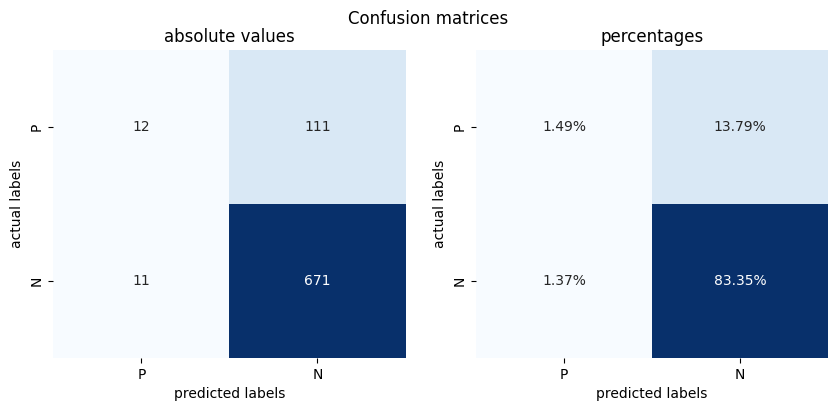

accuracy = 0.8484472049689441
precision = 0.5217391304347826
recall = 0.0975609756097561


In [393]:
display_confusion_matrix(y_test, y_pred)

In [395]:
model.feature_importances_

array([10.73133783,  8.24301863, 10.84225389, 10.56248854,  4.89692276,
        6.37667638,  7.62009612,  6.79367532,  5.34331088, 10.98730865,
        5.00693025, 12.36101559,  0.23496516])

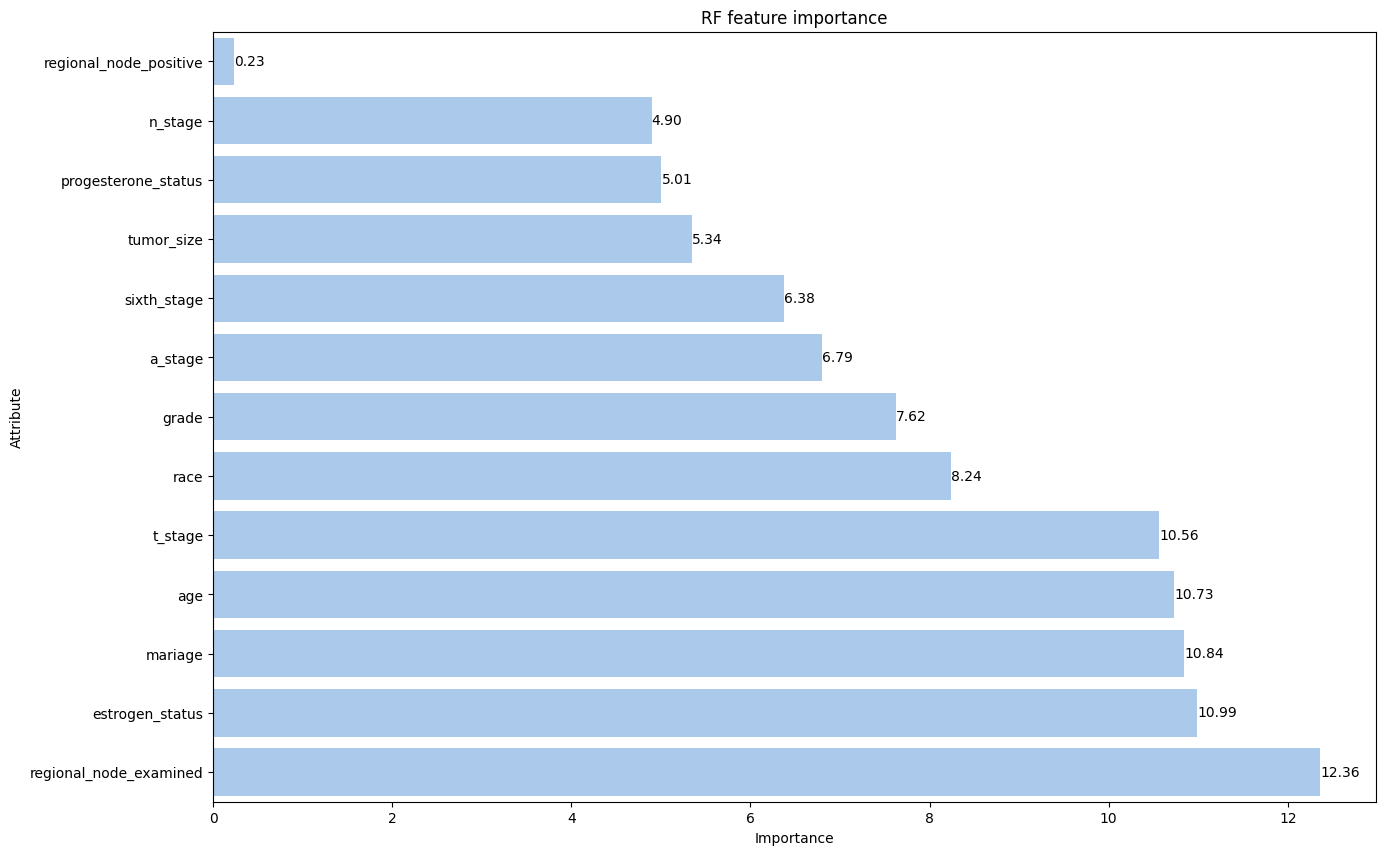

In [397]:
feature_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.set_color_codes("pastel")
ax = sns.barplot(feature_importance.sort_values(by='Importance'), 
            y='Attribute', 
            x='Importance', 
            color="b",
           )
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_title("RF feature importance")
None

### Now with SMOTE

In [406]:
cat_features_indx = [i for i, col in enumerate(X_train.columns) if col in categorical_features]

In [407]:
smt = SMOTENC(categorical_features=cat_features_indx, random_state=42, sampling_strategy='auto') 
smoted_X_train, smoted_y_train = smt.fit_resample(X_train, y_train)

In [410]:
smoted_y_train.value_counts()

0    2725
1    2725
Name: status, dtype: int64

In [425]:
X_train.describe()

,age,tumor_size,estrogen_status,progesterone_status,regional_node_examined,regional_node_positive
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,54.038533,30.625233,0.932878,0.821939,14.286513,4.180547
std,8.960578,21.375123,0.250273,0.382623,8.028970,5.143393
min,30.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,47.000000,16.000000,1.000000,1.000000,9.000000,1.000000
50%,55.000000,25.000000,1.000000,1.000000,14.000000,2.000000
75%,61.000000,38.000000,1.000000,1.000000,19.000000,5.000000
max,69.000000,140.000000,1.000000,1.000000,61.000000,46.000000


In [411]:
lr = LogisticRegression()
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', lr)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression())])

In [412]:
param_grid = {
    'classification__penalty' : ['none', 'l2'],
    'classification__C': np.arange(0.1, 2, 0.1)
}

In [414]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='recall', 
                  cv=5,
                  n_jobs=-1,
                  verbose=2
                 )
gs.fit(smoted_X_train, smoted_y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


C:\Users\Windows\anaconda3\envs\kaggle_env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numeric',
                                                                                          Pipeline(steps=[('scaling',
                                                                                                           StandardScaler())]),
                                                                                          ['age',
                                                                                           'tumor_size',
                                                                                           'regional_node_examined',
                                                                                           'regional_node_positive',
                                                                                           'estrogen_status',
                                                                                           'progesterone_status']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('encoding',
                                                                                                           OneHotEncoder())]),
                                                                                          ['race',
                                                                                           'mariage',
                                                                                           't_stage',
                                                                                           'n_stage',
                                                                                           'sixth_stage',
                                                                                           'grade',
                                                                                           'a_stage'])]))])),
                                       ('classification',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classification__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'classification__penalty': ['none', 'l2']},
             scoring='recall', verbose=2)

In [415]:
gs.best_params_

{'classification__C': 0.9, 'classification__penalty': 'l2'}

In [416]:
gs.best_score_

0.713394495412844

In [418]:
lr = LogisticRegression(C= 0.9, penalty= 'l2')
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', lr)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression(C=0.9))])

In [420]:
model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', LogisticRegression(C=0.9))])

In [421]:
y_pred = model.predict(X_test)

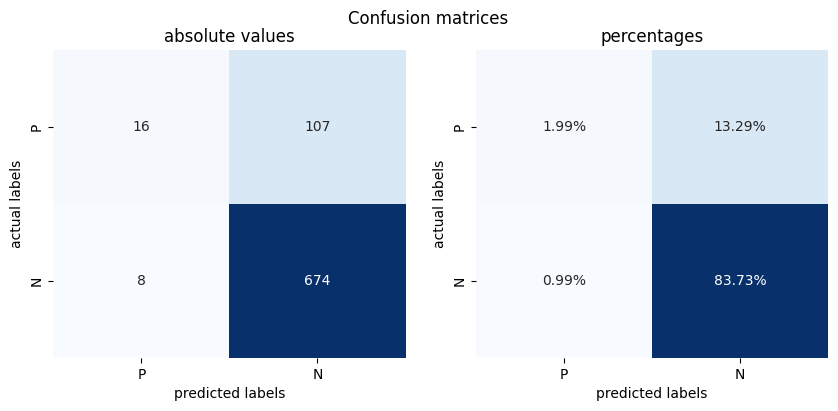

accuracy = 0.8571428571428571
precision = 0.6666666666666666
recall = 0.13008130081300814


In [423]:
display_confusion_matrix(y_test, y_pred)

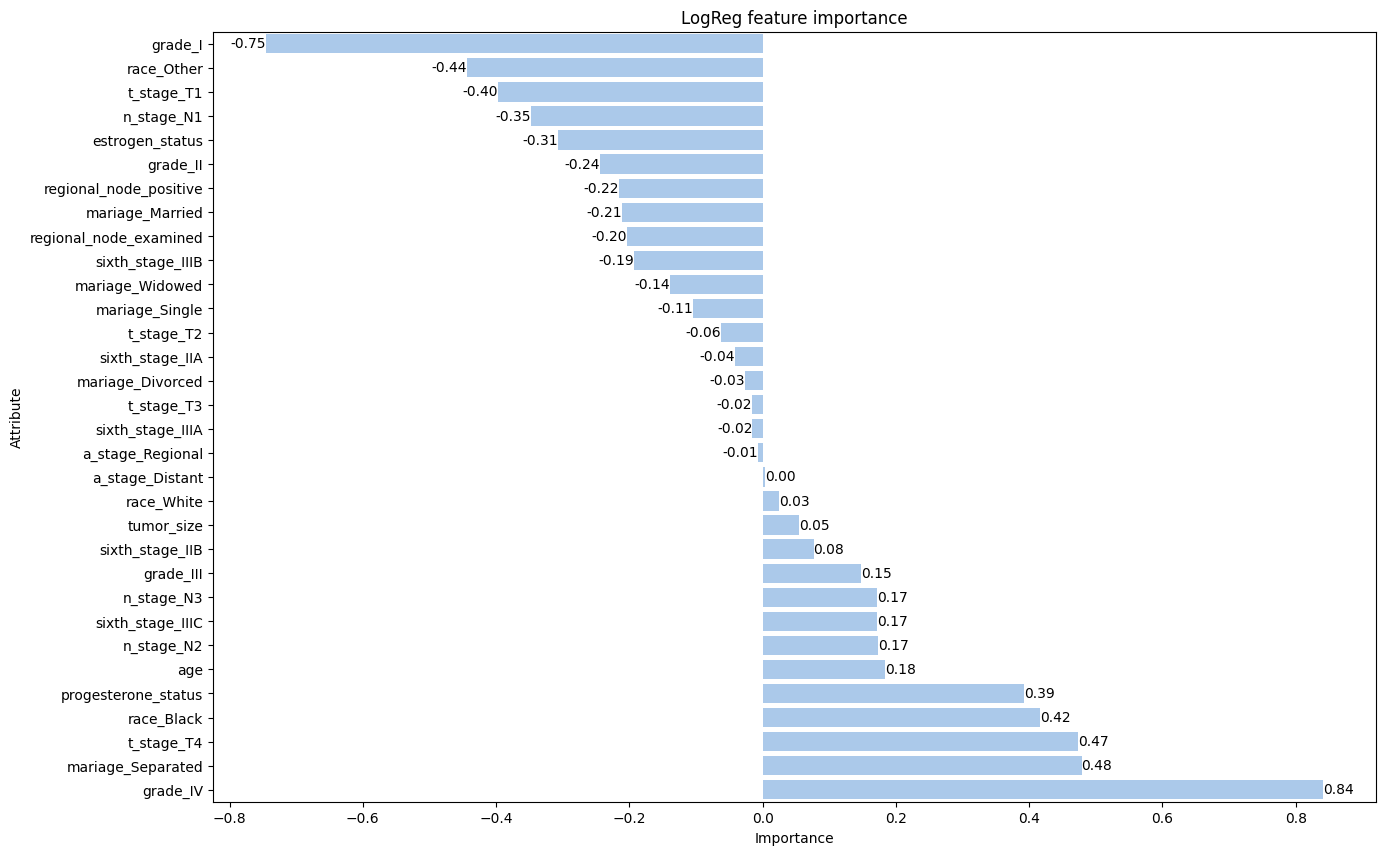

In [424]:
feature_importance = pd.DataFrame(data={
    'Attribute': pd.get_dummies(X_train).columns,
    'Importance': model.named_steps.classification.coef_[0]
})
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.set_color_codes("pastel")
ax = sns.barplot(feature_importance.sort_values(by='Importance'), 
            y='Attribute', 
            x='Importance', 
            color="b",
           )
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_title("LogReg feature importance")
None

RF

In [427]:
rf = RandomForestClassifier()
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', rf)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier())])

In [428]:
param_grid = {
    'classification__n_estimators' : [300, 500, 700, 900, 1100],
    'classification__max_depth' : [3, 4, 5, None],
    'classification__min_samples_leaf' : [1, 2, 4],
    'classification__bootstrap': [True],
}

In [429]:
gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='recall', 
                  cv=5,
                  n_jobs=-1,
                  verbose=10
                 )
gs.fit(smoted_X_train, smoted_y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproc',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numeric',
                                                                                          Pipeline(steps=[('scaling',
                                                                                                           StandardScaler())]),
                                                                                          ['age',
                                                                                           'tumor_size',
                                                                                           'regional_node_examined',
                                                                                           'regional_node_positive',
                                                                                           'estrogen_status',
                                                                                           'progesterone_status']),
                                                                                         ('categorical',
                                                                                          Pipeline(steps=[('encoding',
                                                                                                           OneHotEncoder())]),
                                                                                          ['race',
                                                                                           'mariage',
                                                                                           't_stage',
                                                                                           'n_stage',
                                                                                           'sixth_stage',
                                                                                           'grade',
                                                                                           'a_stage'])]))])),
                                       ('classification',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classification__bootstrap': [True],
                         'classification__max_depth': [3, 4, 5, None],
                         'classification__min_samples_leaf': [1, 2, 4],
                         'classification__n_estimators': [300, 500, 700, 900,
                                                          1100]},
             scoring='recall', verbose=10)

In [430]:
gs.best_score_

0.8579816513761468

In [431]:
gs.best_params_

{'classification__bootstrap': True,
 'classification__max_depth': None,
 'classification__min_samples_leaf': 1,
 'classification__n_estimators': 500}

Actual model

In [432]:
rf = RandomForestClassifier(n_estimators=500, bootstrap=True, max_depth=None, min_samples_leaf=1)
model = Pipeline(steps=[
    ('preproc', preprocessor),
    ('classification', rf)
])
model

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier(n_estimators=500))])

In [433]:
model.fit(smoted_X_train, smoted_y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('data_transformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('scaling',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'tumor_size',
                                                                    'regional_node_examined',
                                                                    'regional_node_positive',
                                                                    'estrogen_status',
                                                                    'progesterone_status']),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['race',
                                                                    'mariage',
                                                                    't_stage',
                                                                    'n_stage',
                                                                    'sixth_stage',
                                                                    'grade',
                                                                    'a_stage'])]))])),
                ('classification', RandomForestClassifier(n_estimators=500))])

In [434]:
y_pred = model.predict(X_test)

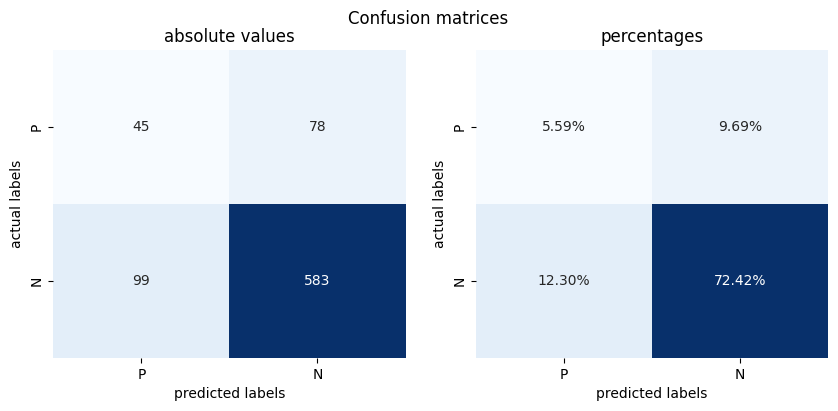

accuracy = 0.7801242236024845
precision = 0.3125
recall = 0.36585365853658536


In [435]:
display_confusion_matrix(y_test, y_pred)

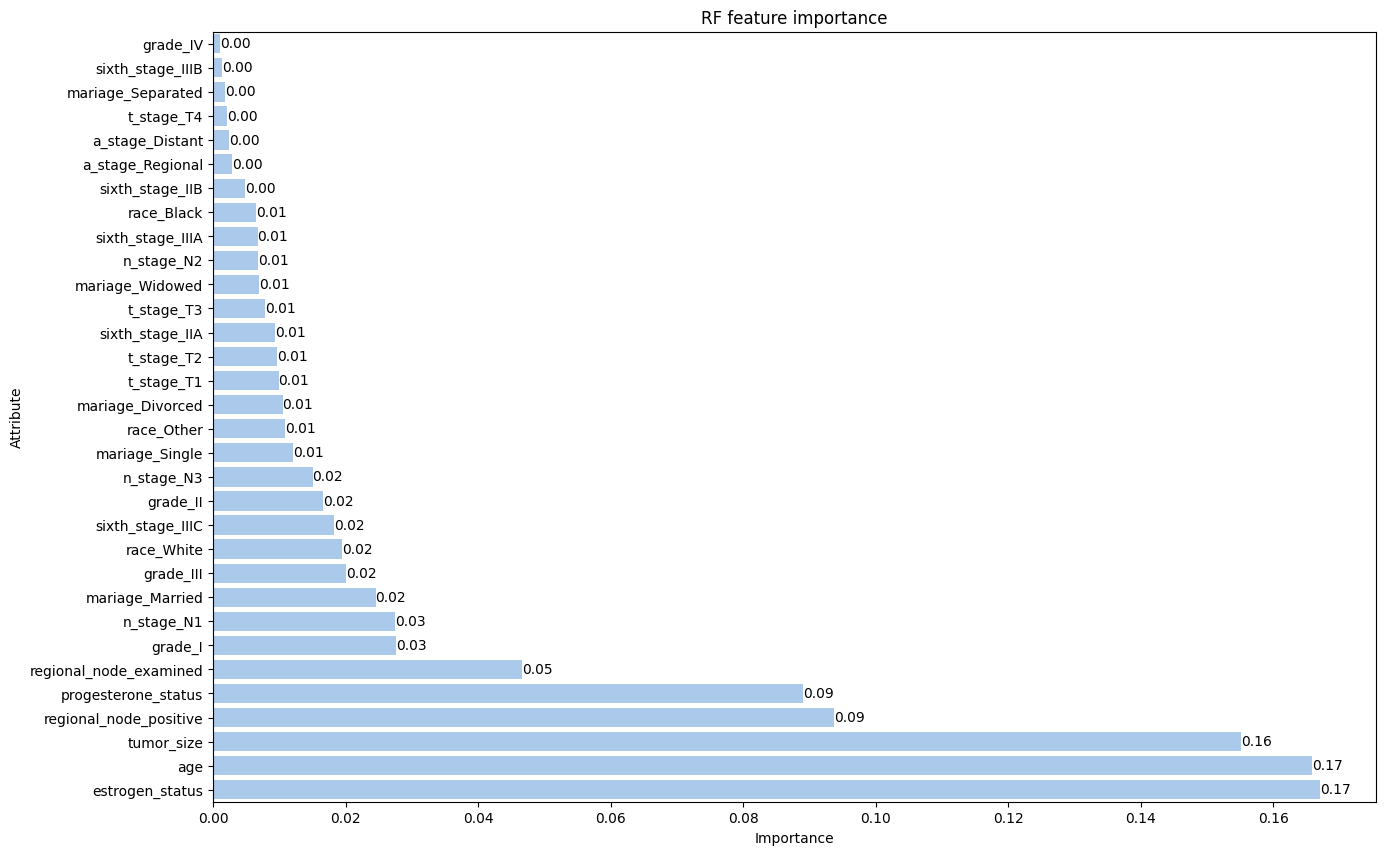

In [437]:
feature_importance = pd.DataFrame(data={
    'Attribute': pd.get_dummies(X_train).columns,
    'Importance': model.named_steps.classification.feature_importances_
})
fig, ax = plt.subplots(1, 1, figsize=(15,10))
sns.set_color_codes("pastel")
ax = sns.barplot(feature_importance.sort_values(by='Importance'), 
            y='Attribute', 
            x='Importance', 
            color="b",
           )
ax.bar_label(ax.containers[-1], fmt='%.2f', label_type='edge')
ax.set_title("RF feature importance")
None